In [7]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


from tqdm import tqdm
from nba_api.stats.static import players, teams
from nba_api.stats.library.parameters import SeasonAll

In [8]:
pd.options.display.max_columns=200

## Compiling and Cleaning Data

In [9]:
team_gamelog = pd.read_csv('./data/gamelog_2018-19.csv')
player_gamelog = pd.read_csv('./data/player_gamelogs_2010-11.csv')

In [10]:
team_gamelog.head(8)

,SEASON_YEAR,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,GP_RANK,W_RANK,L_RANK,W_PCT_RANK,MIN_RANK,FGM_RANK,FGA_RANK,FG_PCT_RANK,FG3M_RANK,FG3A_RANK,FG3_PCT_RANK,FTM_RANK,FTA_RANK,FT_PCT_RANK,OREB_RANK,DREB_RANK,REB_RANK,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK
0,2018-19,1610612751,BKN,Brooklyn Nets,21801221,2019-04-10T00:00:00,BKN vs. MIA,W,48.0,43,114,0.377,21,58,0.362,6,7,0.857,20,48,68,29,12.0,7,3,4,13,12,113,19.0,1,1,1,1,135,760,12,2330,23,8,1130,2408,2440,451,23,20,3,410,636,1203,1731,731,40,2422,1031,226
1,2018-19,1610612766,CHA,Charlotte Hornets,21801222,2019-04-10T00:00:00,CHA vs. ORL,L,48.0,41,78,0.526,8,29,0.276,24,27,0.889,4,28,32,21,8.0,3,4,2,14,19,114,-8.0,1,1231,1231,1231,135,1130,2303,300,1907,1510,2022,331,661,257,2360,2150,2400,1752,96,2301,1329,146,80,1522,959,1711
2,2018-19,1610612744,GSW,Golden State Warriors,21801225,2019-04-10T00:00:00,GSW @ MEM,L,48.0,46,92,0.500,13,30,0.433,12,14,0.857,9,30,39,32,14.0,3,5,0,17,18,117,-15.0,1,1231,1231,1231,135,360,755,535,646,1381,427,1967,2157,451,1362,1905,1966,175,1135,2301,917,1,376,1725,733,2080
3,2018-19,1610612743,DEN,Denver Nuggets,21801228,2019-04-10T00:00:00,DEN vs. MIN,W,48.0,39,87,0.448,10,33,0.303,11,17,0.647,12,41,53,23,13.0,6,4,0,12,22,99,4.0,1,1,1,1,135,1496,1438,1448,1372,972,1785,2083,1894,2154,649,288,267,1394,890,1543,1329,1,23,823,2012,977
4,2018-19,1610612755,PHI,Philadelphia 76ers,21801224,2019-04-10T00:00:00,PHI vs. CHI,W,48.0,52,93,0.559,12,26,0.462,9,15,0.600,9,38,47,30,7.0,4,10,3,11,13,125,16.0,1,1,1,1,135,53,626,94,864,1883,267,2271,2083,2311,1362,610,893,308,35,2133,53,393,11,2382,315,303
5,2018-19,1610612757,POR,Portland Trail Blazers,21801230,2019-04-10T00:00:00,POR vs. SAC,W,48.0,53,91,0.582,14,24,0.583,16,22,0.727,14,30,44,19,13.0,5,2,1,17,17,136,5.0,1,1,1,1,135,34,896,31,462,2090,21,1367,1235,1616,356,1905,1283,2083,890,1855,2069,42,376,1928,57,896
6,2018-19,1610612765,DET,Detroit Pistons,21801223,2019-04-10T00:00:00,DET @ NYK,W,48.0,41,85,0.482,14,33,0.424,19,20,0.950,11,45,56,25,14.0,5,2,5,23,17,115,26.0,1,1,1,1,135,1130,1733,822,462,972,487,903,1526,61,868,75,119,1018,1135,1855,2069,1133,1639,1928,881,97
7,2018-19,1610612742,DAL,Dallas Mavericks,21801227,2019-04-10T00:00:00,DAL @ SAS,L,48.0,37,91,0.407,11,37,0.297,9,12,0.750,7,35,42,27,7.0,5,4,2,19,14,94,-11.0,1,1231,1231,1231,135,1858,896,2089,1110,534,1828,2271,2287,1379,1881,1101,1591,696,35,1855,1329,146,737,2311,2235,1929


In [12]:
def clean_team_gamelog(team_gamelog = team_gamelog):
    df = team_gamelog.copy()
    df = df[['SEASON_YEAR', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
       'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M',
       'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST',
       'TOV', 'STL', 'BLK', 'BLKA', 'PF', 'PFD', 'PTS', 'PLUS_MINUS']]
    
    # Convert GAME_DATE to datetime so it is sortable
    df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])
    
    # Sort by team and date
    df.sort_values(['TEAM_ABBREVIATION', 'GAME_DATE'], inplace=True)
    
    # Combine rows so that one instance shows a game with team stats and opponent stats
    full_gamelogs = pd.merge(df, df, how='inner', on='GAME_ID', suffixes=['', '_opp'])

    # Remove rows that were created where the team is playing itself
    full_gamelogs = full_gamelogs.loc[full_gamelogs['TEAM_ABBREVIATION'] != full_gamelogs['TEAM_ABBREVIATION_opp']]

    # Add column for HOME_GAME
    full_gamelogs['HOME_GAME'] = (full_gamelogs['MATCHUP'].str[:6] == (full_gamelogs['TEAM_ABBREVIATION'].str[:] + ' vs')).astype(int)
    
    full_gamelogs['WIN'] = (full_gamelogs['WL'] == 'W').astype(int)
    full_gamelogs.drop(columns='WL', inplace=True)
    
    full_gamelogs['point_diff'] = full_gamelogs['PLUS_MINUS']
    
    full_gamelogs.sort_values(['TEAM_ABBREVIATION', 'GAME_DATE'], inplace=True)
    
    return full_gamelogs
    
clean_gamelogs_2018 = clean_team_gamelog(team_gamelog)
clean_gamelogs_2018

,SEASON_YEAR,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,SEASON_YEAR_opp,TEAM_ID_opp,TEAM_ABBREVIATION_opp,TEAM_NAME_opp,GAME_DATE_opp,MATCHUP_opp,WL_opp,MIN_opp,FGM_opp,FGA_opp,FG_PCT_opp,FG3M_opp,FG3A_opp,FG3_PCT_opp,FTM_opp,FTA_opp,FT_PCT_opp,OREB_opp,DREB_opp,REB_opp,AST_opp,TOV_opp,STL_opp,BLK_opp,BLKA_opp,PF_opp,PFD_opp,PTS_opp,PLUS_MINUS_opp,HOME_GAME,WIN,point_diff
1,2018-19,1610612737,ATL,Atlanta Hawks,21800007,2018-10-17,ATL @ NYK,48.0,41,90,0.456,10,36,0.278,15,18,0.833,7,38,45,19,24.0,7,3,6,30,23,107,-19.0,2018-19,1610612752,NYK,New York Knicks,2018-10-17,NYK vs. ATL,W,48.0,45,99,0.455,12,33,0.364,24,31,0.774,10,36,46,21,16.0,12,6,3,23,30,126,19.0,0,0,-19.0
5,2018-19,1610612737,ATL,Atlanta Hawks,21800020,2018-10-19,ATL @ MEM,48.0,41,83,0.494,14,30,0.467,21,36,0.583,11,29,40,27,19.0,9,5,4,31,29,117,-14.0,2018-19,1610612763,MEM,Memphis Grizzlies,2018-10-19,MEM vs. ATL,W,48.0,44,81,0.543,13,26,0.500,30,43,0.698,7,34,41,32,17.0,9,4,5,29,31,131,14.0,0,0,-14.0
9,2018-19,1610612737,ATL,Atlanta Hawks,21800036,2018-10-21,ATL @ CLE,48.0,48,98,0.490,22,47,0.468,15,19,0.789,9,35,44,32,12.0,9,7,2,21,25,133,22.0,2018-19,1610612739,CLE,Cleveland Cavaliers,2018-10-21,CLE vs. ATL,L,48.0,46,99,0.465,10,27,0.370,9,14,0.643,15,34,49,23,18.0,5,2,7,25,21,111,-22.0,0,1,22.0
13,2018-19,1610612737,ATL,Atlanta Hawks,21800052,2018-10-24,ATL vs. DAL,48.0,37,91,0.407,15,38,0.395,22,31,0.710,10,44,54,28,15.0,6,6,9,26,27,111,7.0,2018-19,1610612742,DAL,Dallas Mavericks,2018-10-24,DAL @ ATL,L,48.0,38,91,0.418,12,40,0.300,16,26,0.615,9,43,52,25,17.0,7,9,6,27,26,104,-7.0,1,1,7.0
17,2018-19,1610612737,ATL,Atlanta Hawks,21800076,2018-10-27,ATL vs. CHI,48.0,27,84,0.321,12,40,0.300,19,23,0.826,11,37,48,20,22.0,9,8,6,13,21,85,-12.0,2018-19,1610612741,CHI,Chicago Bulls,2018-10-27,CHI @ ATL,W,48.0,36,83,0.434,12,33,0.364,13,16,0.813,8,44,52,25,23.0,14,6,8,21,13,97,12.0,1,0,-12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2266,2018-19,1610612764,WAS,Washington Wizards,21801148,2019-03-31,WAS @ DEN,48.0,37,92,0.402,6,24,0.250,15,20,0.750,9,45,54,24,12.0,9,6,5,21,18,95,5.0,2018-19,1610612743,DEN,Denver Nuggets,2019-03-31,DEN vs. WAS,L,48.0,35,93,0.376,7,36,0.194,13,20,0.650,12,45,57,18,11.0,6,5,6,18,21,90,-5.0,0,1,5.0
1478,2018-19,1610612764,WAS,Washington Wizards,21801167,2019-04-03,WAS vs. CHI,48.0,45,97,0.464,5,27,0.185,19,26,0.731,9,30,39,24,12.0,8,9,5,18,23,114,-1.0,2018-19,1610612741,CHI,Chicago Bulls,2019-04-03,CHI @ WAS,W,48.0,48,90,0.533,5,19,0.263,14,17,0.824,9,40,49,22,20.0,7,5,9,23,18,115,1.0,1,0,-1.0
4886,2018-19,1610612764,WAS,Washington Wizards,21801182,2019-04-05,WAS vs. SAS,48.0,42,88,0.477,9,32,0.281,19,22,0.864,9,25,34,22,10.0,2,4,4,16,18,112,-17.0,2018-19,1610612759,SAS,San Antonio Spurs,2019-04-05,SAS @ WAS,W,48.0,51,91,0.560,10,25,0.400,17,20,0.850,12,30,42,34,9.0,3,4,4,18,16,129,17.0,1,0,-17.0
4414,2018-19,1610612764,WAS,Washington Wizards,21801204,2019-04-07,WAS @ NYK,48.0,43,103,0.417,10,34,0.294,14,18,0.778,21,29,50,24,9.0,12,4,9,16,14,110,-3.0,2018-19,1610612752,NYK,New York Knicks,2019-04-07,NYK vs. WAS,W,48.0,41,80,0.513,17,34,0.500,14,19,0.737,7,36,43,24,15.0,5,9,4,14,16,113,3.0,0,0,-3.0


In [53]:
def get_cumulative_stats(df, n=5):
    df = df.copy()
    stats = ['MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M',
       'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST',
       'TOV', 'STL', 'BLK', 'BLKA', 'PF', 'PFD', 'PTS', 'PLUS_MINUS',
       'FGM_opp', 'FGA_opp', 'FG_PCT_opp', 'FG3M_opp', 'FG3A_opp',
       'FG3_PCT_opp', 'FTM_opp', 'FTA_opp', 'FT_PCT_opp', 'OREB_opp',
       'DREB_opp', 'REB_opp', 'AST_opp', 'TOV_opp', 'STL_opp', 'BLK_opp',
       'BLKA_opp', 'PF_opp', 'PFD_opp', 'PTS_opp', 'PLUS_MINUS_opp',
       'WIN']
    all_teams_cume_stats = []
    
    team_abbreviations = df['TEAM_ABBREVIATION'].unique()
    for team in team_abbreviations:
        team_df = df.loc[df['TEAM_ABBREVIATION'] == team].sort_values(['GAME_DATE'])        
        team_df[stats] = team_df[stats].shift(1).expanding(min_periods=5).mean()
        last_n_games = df.loc[df['TEAM_ABBREVIATION'] == team].sort_values(['GAME_DATE'])    

        last_n_games[stats] = last_n_games[stats].shift(1).rolling(n, min_periods=5).mean()
        combined_df = pd.merge(team_df, last_n_games[stats], left_index=True, right_index=True, suffixes =['_avg', '_last{}'.format(n)])
        combined_df.sort_values(['GAME_DATE'], inplace=True)
        all_teams_cume_stats.append(combined_df)
        
    full_df = pd.concat(all_teams_cume_stats)
    
    return full_df


full_gamelogs_cume = get_cumulative_stats(clean_gamelogs_2018)
full_gamelogs_cume
        

,SEASON_YEAR,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,MIN_avg,FGM_avg,FGA_avg,FG_PCT_avg,FG3M_avg,FG3A_avg,FG3_PCT_avg,FTM_avg,FTA_avg,FT_PCT_avg,OREB_avg,DREB_avg,REB_avg,AST_avg,TOV_avg,STL_avg,BLK_avg,BLKA_avg,PF_avg,PFD_avg,PTS_avg,PLUS_MINUS_avg,SEASON_YEAR_opp,TEAM_ID_opp,TEAM_ABBREVIATION_opp,TEAM_NAME_opp,GAME_DATE_opp,MATCHUP_opp,WL_opp,MIN_opp,FGM_opp_avg,FGA_opp_avg,FG_PCT_opp_avg,FG3M_opp_avg,FG3A_opp_avg,FG3_PCT_opp_avg,FTM_opp_avg,FTA_opp_avg,FT_PCT_opp_avg,OREB_opp_avg,DREB_opp_avg,REB_opp_avg,AST_opp_avg,TOV_opp_avg,STL_opp_avg,BLK_opp_avg,BLKA_opp_avg,PF_opp_avg,PFD_opp_avg,PTS_opp_avg,PLUS_MINUS_opp_avg,HOME_GAME,WIN_avg,point_diff,MIN_last5,FGM_last5,FGA_last5,FG_PCT_last5,FG3M_last5,FG3A_last5,FG3_PCT_last5,FTM_last5,FTA_last5,FT_PCT_last5,OREB_last5,DREB_last5,REB_last5,AST_last5,TOV_last5,STL_last5,BLK_last5,BLKA_last5,PF_last5,PFD_last5,PTS_last5,PLUS_MINUS_last5,FGM_opp_last5,FGA_opp_last5,FG_PCT_opp_last5,FG3M_opp_last5,FG3A_opp_last5,FG3_PCT_opp_last5,FTM_opp_last5,FTA_opp_last5,FT_PCT_opp_last5,OREB_opp_last5,DREB_opp_last5,REB_opp_last5,AST_opp_last5,TOV_opp_last5,STL_opp_last5,BLK_opp_last5,BLKA_opp_last5,PF_opp_last5,PFD_opp_last5,PTS_opp_last5,PLUS_MINUS_opp_last5,WIN_last5
1,2018-19,1610612737,ATL,Atlanta Hawks,21800007,2018-10-17,ATL @ NYK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-19,1610612752,NYK,New York Knicks,2018-10-17,NYK vs. ATL,W,48.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,-19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2018-19,1610612737,ATL,Atlanta Hawks,21800020,2018-10-19,ATL @ MEM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-19,1610612763,MEM,Memphis Grizzlies,2018-10-19,MEM vs. ATL,W,48.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,-14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2018-19,1610612737,ATL,Atlanta Hawks,21800036,2018-10-21,ATL @ CLE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-19,1610612739,CLE,Cleveland Cavaliers,2018-10-21,CLE vs. ATL,L,48.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,2018-19,1610612737,ATL,Atlanta Hawks,21800052,2018-10-24,ATL vs. DAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-19,1610612742,DAL,Dallas Mavericks,2018-10-24,DAL @ ATL,L,48.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,2018-19,1610612737,ATL,Atlanta Hawks,21800076,2018-10-27,ATL vs. CHI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-19,1610612741,CHI,Chicago Bulls,2018-10-27,CHI @ ATL,W,48.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,-12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [57]:
full_gamelogs_cume[['PFD_avg', 'PF_opp_avg']]

,PFD_avg,PF_opp_avg
1,NaN,NaN
5,NaN,NaN
9,NaN,NaN
13,NaN,NaN
17,NaN,NaN
...,...,...
2266,21.441558,21.441558
1478,21.397436,21.397436
4886,21.417722,21.417722
4414,21.375000,21.375000


In [71]:
def get_weighted_cume_stats(df, n=10):
    df = df.copy()
    stats = ['MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M',
       'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST',
       'TOV', 'STL', 'BLK', 'BLKA', 'PF', 'PFD', 'PTS', 'PLUS_MINUS',
       'FGM_opp', 'FGA_opp', 'FG_PCT_opp', 'FG3M_opp', 'FG3A_opp',
       'FG3_PCT_opp', 'FTM_opp', 'FTA_opp', 'FT_PCT_opp', 'OREB_opp',
       'DREB_opp', 'REB_opp', 'AST_opp', 'TOV_opp', 'STL_opp', 'BLK_opp',
       'BLKA_opp', 'PF_opp', 'PFD_opp', 'PTS_opp', 'PLUS_MINUS_opp',
       'WIN']
    all_teams_cume_stats = []
    
    team_abbreviations = df['TEAM_ABBREVIATION'].unique()
    
    weights = np.array([0.05, 0.05, 0.05, 0.05, 0.10,
                       0.10, 0.10, 0.15, 0.15, 0.20])
    
    sum_weights = np.sum(weights)
    
    for team in team_abbreviations:
        team_df = df.loc[df['TEAM_ABBREVIATION'] == team].sort_values(['GAME_DATE'])        
        team_df[stats] = (team_df[stats].shift(1).rolling(window=n)
                         .apply(lambda row: np.sum(weights*row) / sum_weights, raw=False))
                        
        
        
        team_df.sort_values(['GAME_DATE'], inplace=True)
        all_teams_cume_stats.append(team_df)
        
    full_df = pd.concat(all_teams_cume_stats)
    
    return full_df

weighted_stats_2018 = get_weighted_cume_stats(clean_gamelogs_2018)
weighted_stats_2018

,SEASON_YEAR,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,SEASON_YEAR_opp,TEAM_ID_opp,TEAM_ABBREVIATION_opp,TEAM_NAME_opp,GAME_DATE_opp,MATCHUP_opp,WL_opp,MIN_opp,FGM_opp,FGA_opp,FG_PCT_opp,FG3M_opp,FG3A_opp,FG3_PCT_opp,FTM_opp,FTA_opp,FT_PCT_opp,OREB_opp,DREB_opp,REB_opp,AST_opp,TOV_opp,STL_opp,BLK_opp,BLKA_opp,PF_opp,PFD_opp,PTS_opp,PLUS_MINUS_opp,HOME_GAME,WIN,point_diff
1,2018-19,1610612737,ATL,Atlanta Hawks,21800007,2018-10-17,ATL @ NYK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-19,1610612752,NYK,New York Knicks,2018-10-17,NYK vs. ATL,W,48.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,-19.0
5,2018-19,1610612737,ATL,Atlanta Hawks,21800020,2018-10-19,ATL @ MEM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-19,1610612763,MEM,Memphis Grizzlies,2018-10-19,MEM vs. ATL,W,48.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,-14.0
9,2018-19,1610612737,ATL,Atlanta Hawks,21800036,2018-10-21,ATL @ CLE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-19,1610612739,CLE,Cleveland Cavaliers,2018-10-21,CLE vs. ATL,L,48.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,22.0
13,2018-19,1610612737,ATL,Atlanta Hawks,21800052,2018-10-24,ATL vs. DAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-19,1610612742,DAL,Dallas Mavericks,2018-10-24,DAL @ ATL,L,48.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,7.0
17,2018-19,1610612737,ATL,Atlanta Hawks,21800076,2018-10-27,ATL vs. CHI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-19,1610612741,CHI,Chicago Bulls,2018-10-27,CHI @ ATL,W,48.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,-12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2266,2018-19,1610612764,WAS,Washington Wizards,21801148,2019-03-31,WAS @ DEN,48.50,42.30,90.20,0.46930,10.65,32.10,0.32810,19.65,26.40,0.74680,11.80,32.85,44.65,24.30,13.40,7.75,3.75,5.85,18.40,21.65,114.90,-5.15,2018-19,1610612743,DEN,Denver Nuggets,2019-03-31,DEN vs. WAS,L,48.0,46.15,90.50,0.51120,12.95,32.80,0.40185,14.80,18.30,0.80435,10.85,34.90,45.75,28.55,14.6,7.95,5.85,3.75,21.65,18.40,120.05,5.15,0,0.25,5.0
1478,2018-19,1610612764,WAS,Washington Wizards,21801167,2019-04-03,WAS vs. CHI,48.25,41.05,90.05,0.45655,9.70,30.00,0.31700,19.60,26.20,0.75400,11.35,35.25,46.60,24.20,13.05,8.00,4.05,6.00,19.00,21.55,111.40,-3.25,2018-19,1610612741,CHI,Chicago Bulls,2019-04-03,CHI @ WAS,W,48.0,44.10,90.50,0.48880,11.90,33.95,0.35780,14.55,18.95,0.76175,10.85,36.70,47.55,26.25,13.7,7.70,6.00,4.05,21.55,19.00,114.65,3.25,1,0.40,-1.0
4886,2018-19,1610612764,WAS,Washington Wizards,21801182,2019-04-05,WAS vs. SAS,48.25,42.00,92.20,0.45565,8.90,29.85,0.29010,19.45,26.25,0.74195,11.25,33.70,44.95,24.40,12.90,8.05,5.05,5.85,19.10,22.00,112.35,-3.30,2018-19,1610612759,SAS,San Antonio Spurs,2019-04-05,SAS @ WAS,W,48.0,45.20,90.10,0.50270,10.45,31.05,0.33585,14.80,18.90,0.78020,10.30,37.50,47.80,26.25,15.4,7.35,5.85,5.05,22.00,19.10,115.65,3.30,1,0.30,-17.0
4414,2018-19,1610612764,WAS,Washington Wizards,21801204,2019-04-07,WAS @ NYK,48.25,41.65,91.20,0.45670,8.40,29.80,0.27750,19.00,24.95,0.76985,10.50,32.30,42.80,23.45,12.40,6.95,4.80,5.40,18.45,20.85,110.70,-6.55,2018-19,1610612752,NYK,New York Knicks,2019-04-07,NYK vs. WAS,W,48.0,46.00,90.55,0.50880,10.30,29.90,0.34720,14.95,18.90,0.78635,10.90,36.45,47.35,27.45,14.2,6.

In [72]:
weighted_stats_2018.loc[weighted_stats_2018['TEAM_ABBREVIATION'] == 'ATL']

,SEASON_YEAR,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,SEASON_YEAR_opp,TEAM_ID_opp,TEAM_ABBREVIATION_opp,TEAM_NAME_opp,GAME_DATE_opp,MATCHUP_opp,WL_opp,MIN_opp,FGM_opp,FGA_opp,FG_PCT_opp,FG3M_opp,FG3A_opp,FG3_PCT_opp,FTM_opp,FTA_opp,FT_PCT_opp,OREB_opp,DREB_opp,REB_opp,AST_opp,TOV_opp,STL_opp,BLK_opp,BLKA_opp,PF_opp,PFD_opp,PTS_opp,PLUS_MINUS_opp,HOME_GAME,WIN,point_diff
1,2018-19,1610612737,ATL,Atlanta Hawks,21800007,2018-10-17,ATL @ NYK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-19,1610612752,NYK,New York Knicks,2018-10-17,NYK vs. ATL,W,48.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,-19.0
5,2018-19,1610612737,ATL,Atlanta Hawks,21800020,2018-10-19,ATL @ MEM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-19,1610612763,MEM,Memphis Grizzlies,2018-10-19,MEM vs. ATL,W,48.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,-14.0
9,2018-19,1610612737,ATL,Atlanta Hawks,21800036,2018-10-21,ATL @ CLE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-19,1610612739,CLE,Cleveland Cavaliers,2018-10-21,CLE vs. ATL,L,48.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,22.0
13,2018-19,1610612737,ATL,Atlanta Hawks,21800052,2018-10-24,ATL vs. DAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-19,1610612742,DAL,Dallas Mavericks,2018-10-24,DAL @ ATL,L,48.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,7.0
17,2018-19,1610612737,ATL,Atlanta Hawks,21800076,2018-10-27,ATL vs. CHI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-19,1610612741,CHI,Chicago Bulls,2018-10-27,CHI @ ATL,W,48.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,-12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,2018-19,1610612737,ATL,Atlanta Hawks,21801162,2019-04-02,ATL @ SAS,49.00,44.65,99.55,0.44875,16.35,46.10,0.35265,14.40,18.60,0.77105,11.35,36.60,47.95,28.70,13.35,8.50,6.05,4.25,21.50,17.90,120.05,-1.70,2018-19,1610612759,SAS,San Antonio Spurs,2019-04-02,SAS vs. ATL,W,48.0,42.70,94.75,0.45355,13.15,38.80,0.34175,23.20,28.60,0.82825,12.25,39.65,51.90,25.85,15.00,8.30,4.25,6.05,17.90,21.50,121.75,1.70,0,0.65,-6.0
313,2018-19,1610612737,ATL,Atlanta Hawks,21801168,2019-04-03,ATL vs. PHI,48.75,44.10,98.50,0.44770,15.10,43.45,0.34485,14.00,18.80,0.74575,11.45,35.10,46.55,27.60,12.85,9.45,5.45,4.45,21.40,17.45,117.30,-3.25,2018-19,1610612755,PHI,Philadelphia 76ers,2019-04-03,PHI @ ATL,L,48.0,42.50,91.85,0.46640,12.65,35.95,0.35990,22.90,27.95,0.82905,11.00,40.15,51.15,24.70,15.30,7.75,4.45,5.45,17.45,21.40,120.55,3.25,1,0.50,8.0
317,2018-19,1610612737,ATL,Atlanta Hawks,21801181,2019-04-05,ATL @ ORL,48.75,45.00,98.00,0.46025,14.65,42.80,0.33930,15.75,20.85,0.74990,11.50,34.95,46.45,28.05,12.55,9.10,5.70,4.30,22.15,18.90,120.40,-1.55,2018-19,1610612753,ORL,Orlando Magic,2019-04-05,ORL vs. ATL,W,48.0,43.10,93.50,0.46430,12.30,35.45,0.35395,23.45,30.75,0.78345,14.35,39.00,53.35,25.35,15.15,7.85,4.30,5.70,18.90,22.15,121.95,1.55,0,0.60,-36.0
321,2018-19,1610612737,ATL,Atlanta Hawks,21801202,2019-04-07,ATL @ MIL,48.50,43.60,96.00,0.45470,13.45,41.40,0.32110,16.60,22.55,0.73890,10.50,33.50,44.00,26.25,12.90,10.50,5.05,4.20,21.90,19.70,117.25,-8.85,2018-19,1610612749,MIL,Milwaukee Bucks,2019-04-07,MIL vs. ATL,W,48.0,45.35,92.00,0.49570,13.40,35.60,0.37975,22.00,28.90,0.77850,12.50,40.35,52.85,26.95,16.10,8.50,4.20,5.05

In [75]:
def final_preparation(df = full_gamelogs_cume):
       
    # Merge the data once more, since we have team A's data, Team A's opponent's data, Team B's data ,Team B's opponent's data  
    final_merged_df = pd.merge(df, df, on='GAME_ID')

    # Filter out non-sense rows where the same team is playing itself
    final_merged_df = final_merged_df.loc[final_merged_df['TEAM_ABBREVIATION_x'] != final_merged_df['TEAM_ABBREVIATION_y']]

    # Only take the home games (This will include the entire season, as one team is always at home)
    # It just makes it so the home team is always the first set of stats
    final_merged_df = final_merged_df.loc[final_merged_df['HOME_GAME_x'] == 1]

    # Resort the data in chronological order
    final_merged_df = final_merged_df.sort_values(['GAME_DATE_x'])

    # For readability, rename columns    
    new_col_names = ['HOME_' + x[:-2] if x[-2:] == '_x' else 'AWAY_' + x[:-2] for x in final_merged_df.columns.to_list()]
    final_merged_df.columns = new_col_names
    
    final_merged_df.rename(columns={'HOME_point_diff':'point_diff'}, inplace=True)
    
    # Drop unnecessary columns
    final_merged_df = final_merged_df.drop(columns=['HOME_TEAM_ID', 'HOME_TEAM_NAME', 'HOME_MATCHUP', 'HOME_HOME_GAME', 'AWAY_GAME_', 
                                     'AWAY_SEASON_YEAR', 'AWAY_TEAM_ID', 'AWAY_MATCHUP', 'AWAY_TEAM_NAME', 'AWAY_GAME_DATE', 'AWAY_HOME_GAME'])
    final_merged_df.dropna(inplace=True)
    return final_merged_df

final_merged_df_2018 = final_preparation(df=full_gamelogs_cume)
final_merged_df_2018
                                                  
                               
                                                  
                                                

,HOME_SEASON_YEAR,HOME_TEAM_ABBREVIATION,HOME_GAME_DATE,HOME_MIN_avg,HOME_FGM_avg,HOME_FGA_avg,HOME_FG_PCT_avg,HOME_FG3M_avg,HOME_FG3A_avg,HOME_FG3_PCT_avg,HOME_FTM_avg,HOME_FTA_avg,HOME_FT_PCT_avg,HOME_OREB_avg,HOME_DREB_avg,HOME_REB_avg,HOME_AST_avg,HOME_TOV_avg,HOME_STL_avg,HOME_BLK_avg,HOME_BLKA_avg,HOME_PF_avg,HOME_PFD_avg,HOME_PTS_avg,HOME_PLUS_MINUS_avg,HOME_SEASON_YEAR_opp,HOME_TEAM_ID_opp,HOME_TEAM_ABBREVIATION_opp,HOME_TEAM_NAME_opp,HOME_GAME_DATE_opp,HOME_MATCHUP_opp,HOME_WL_opp,HOME_MIN_opp,HOME_FGM_opp_avg,HOME_FGA_opp_avg,HOME_FG_PCT_opp_avg,HOME_FG3M_opp_avg,HOME_FG3A_opp_avg,HOME_FG3_PCT_opp_avg,HOME_FTM_opp_avg,HOME_FTA_opp_avg,HOME_FT_PCT_opp_avg,HOME_OREB_opp_avg,HOME_DREB_opp_avg,HOME_REB_opp_avg,HOME_AST_opp_avg,HOME_TOV_opp_avg,HOME_STL_opp_avg,HOME_BLK_opp_avg,HOME_BLKA_opp_avg,HOME_PF_opp_avg,HOME_PFD_opp_avg,HOME_PTS_opp_avg,HOME_PLUS_MINUS_opp_avg,HOME_WIN_avg,point_diff,HOME_MIN_last5,HOME_FGM_last5,HOME_FGA_last5,HOME_FG_PCT_last5,HOME_FG3M_last5,HOME_FG3A_last5,HOME_FG3_PCT_last5,HOME_FTM_last5,HOME_FTA_last5,HOME_FT_PCT_last5,HOME_OREB_last5,HOME_DREB_last5,HOME_REB_last5,HOME_AST_last5,HOME_TOV_last5,HOME_STL_last5,HOME_BLK_last5,HOME_BLKA_last5,HOME_PF_last5,HOME_PFD_last5,HOME_PTS_last5,HOME_PLUS_MINUS_last5,HOME_FGM_opp_last5,HOME_FGA_opp_last5,HOME_FG_PCT_opp_last5,HOME_FG3M_opp_last5,HOME_FG3A_opp_last5,HOME_FG3_PCT_opp_last5,HOME_FTM_opp_last5,HOME_FTA_opp_last5,HOME_FT_PCT_opp_last5,HOME_OREB_opp_last5,HOME_DREB_opp_last5,HOME_REB_opp_last5,HOME_AST_opp_last5,HOME_TOV_opp_last5,HOME_STL_opp_last5,HOME_BLK_opp_last5,HOME_BLKA_opp_last5,HOME_PF_opp_last5,HOME_PFD_opp_last5,HOME_PTS_opp_last5,HOME_PLUS_MINUS_opp_last5,HOME_WIN_last5,AWAY_TEAM_ABBREVIATION,AWAY_MIN_avg,AWAY_FGM_avg,AWAY_FGA_avg,AWAY_FG_PCT_avg,AWAY_FG3M_avg,AWAY_FG3A_avg,AWAY_FG3_PCT_avg,AWAY_FTM_avg,AWAY_FTA_avg,AWAY_FT_PCT_avg,AWAY_OREB_avg,AWAY_DREB_avg,AWAY_REB_avg,AWAY_AST_avg,AWAY_TOV_avg,AWAY_STL_avg,AWAY_BLK_avg,AWAY_BLKA_avg,AWAY_PF_avg,AWAY_PFD_avg,AWAY_PTS_avg,AWAY_PLUS_MINUS_avg,AWAY_SEASON_YEAR_opp,AWAY_TEAM_ID_opp,AWAY_TEAM_ABBREVIATION_opp,AWAY_TEAM_NAME_opp,AWAY_GAME_DATE_opp,AWAY_MATCHUP_opp,AWAY_WL_opp,AWAY_MIN_opp,AWAY_FGM_opp_avg,AWAY_FGA_opp_avg,AWAY_FG_PCT_opp_avg,AWAY_FG3M_opp_avg,AWAY_FG3A_opp_avg,AWAY_FG3_PCT_opp_avg,AWAY_FTM_opp_avg,AWAY_FTA_opp_avg,AWAY_FT_PCT_opp_avg,AWAY_OREB_opp_avg,AWAY_DREB_opp_avg,AWAY_REB_opp_avg,AWAY_AST_opp_avg,AWAY_TOV_opp_avg,AWAY_STL_opp_avg,AWAY_BLK_opp_avg,AWAY_BLKA_opp_avg,AWAY_PF_opp_avg,AWAY_PFD_opp_avg,AWAY_PTS_opp_avg,AWAY_PLUS_MINUS_opp_avg,AWAY_WIN_avg,AWAY_point_diff,AWAY_MIN_last5,AWAY_FGM_last5,AWAY_FGA_last5,AWAY_FG_PCT_last5,AWAY_FG3M_last5,AWAY_FG3A_last5,AWAY_FG3_PCT_last5,AWAY_FTM_last5,AWAY_FTA_last5,AWAY_FT_PCT_last5,AWAY_OREB_last5,AWAY_DREB_last5,AWAY_REB_last5,AWAY_AST_last5,AWAY_TOV_last5,AWAY_STL_last5,AWAY_BLK_last5,AWAY_BLKA_last5,AWAY_PF_last5,AWAY_PFD_last5,AWAY_PTS_last5,AWAY_PLUS_MINUS_last5,AWAY_FGM_opp_last5,AWAY_FGA_opp_last5,AWAY_FG_PCT_opp_last5,AWAY_FG3M_opp_last5,AWAY_FG3A_opp_last5,AWAY_FG3_PCT_opp_last5,AWAY_FTM_opp_last5,AWAY_FTA_opp_last5,AWAY_FT_PCT_opp_last5,AWAY_OREB_opp_last5,AWAY_DREB_opp_last5,AWAY_REB_opp_last5,AWAY_AST_opp_last5,AWAY_TOV_opp_last5,AWAY_STL_opp_last5,AWAY_BLK_opp_last5,AWAY_BLKA_opp_last5,AWAY_PF_opp_last5,AWAY_PFD_opp_last5,AWAY_PTS_opp_last5,AWAY_PLUS_MINUS_opp_last5,AWAY_WIN_last5
2534,2018-19,NYK,2018-10-26,48.000000,39.600000,94.600000,0.417800,11.000000,31.600000,0.347400,16.200000,21.400000,0.762800,10.800000,32.400000,43.200000,20.000000,11.800000,8.200000,2.600000,5.000000,22.200000,22.400000,106.400000,-3.800000,2018-19,1610612744,GSW,Golden State Warriors,2018-10-26,GSW @ NYK,W,48.0,39.000000,85.000000,0.459200,12.200000,32.000000,0.382200,20.000000,25.400000,0.788600,10.600000,40.000000,50.600000,22.600000,17.800000,5.800000,5.000000,2.600000,22.400000,22.200000,110.200000,3.800000,0.200000,-28.0,48.0,39.6,94.6,0.4178,11.0,31.6,0.3474,16.2,21.4,0.7628,10.8,32.4,43.2,20.0,11.8,8.2,2.6,5.0,22.2,22.

## Feature Selection

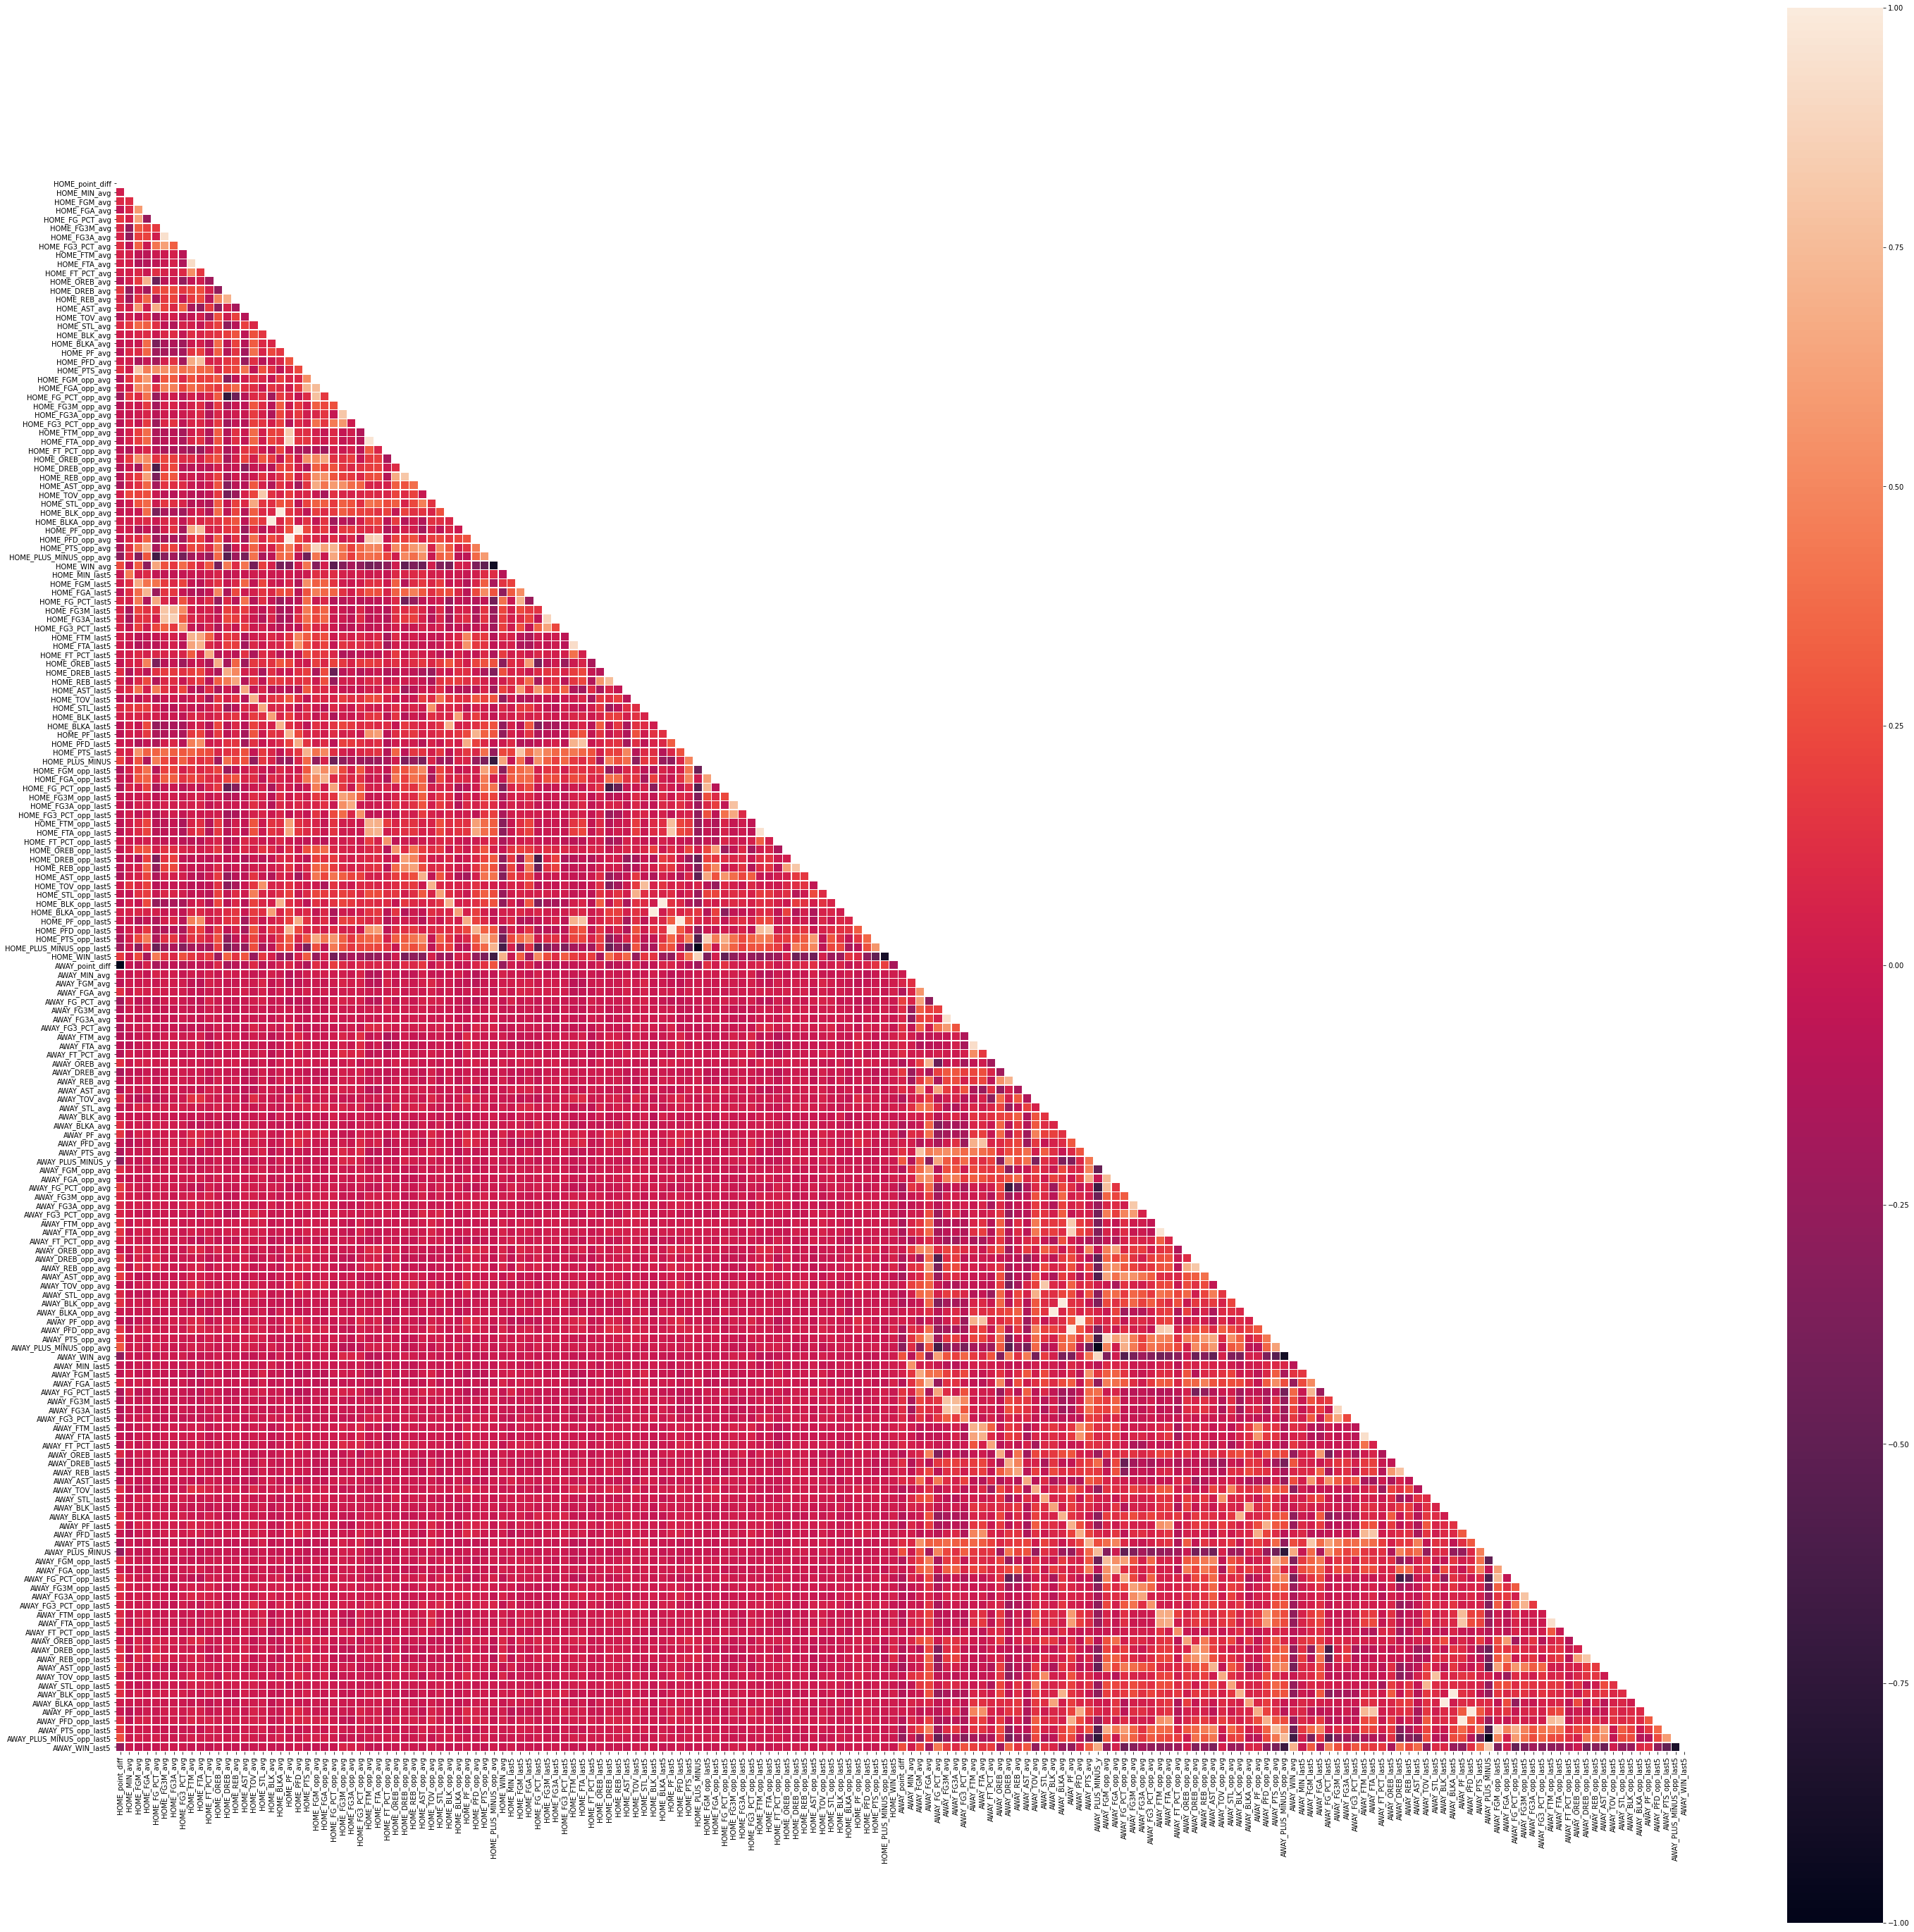

In [418]:
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold

corr = final_merged_df.drop(columns=['HOME_TEAM_ABBREVIATION', 'AWAY_TEAM_ABBREVIATION']).corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

fig, ax = plt.subplots(figsize=(50,50))

sns.heatmap(corr, mask=mask, square=True, linewidths=0.5)

plt.savefig('correlations.jpg')


In [199]:
def remove_correlated_features(final_merged_df, threshold=1):
    """Removes correlated features from dataset
    INPUTS:
    final_merged_df
    threshold: float between 0 and 1 indicating how highly correlated features
    must be to be removed
    OUTPUT: final_merged_df with the correlated feature columns removed
    """
    corr = final_merged_df.select_dtypes('number').corr()

    correlated_features = set()
    for i in range(len(corr.columns)):
        for j in range(i):
            if abs(corr.iloc[i, j]) >= threshold:
                colname = corr.columns[i]
                correlated_features.add(colname)
    print("Correlated Features:", list(correlated_features))
    print("Num Features Removed ", len(correlated_features))
    final_merged_df.drop(columns=list(correlated_features), inplace=True)
    return final_merged_df

In [137]:
# Remove perfectly correlated features
final_merged_df = remove_correlated_features(final_merged_df_2018)
final_merged_df

Correlated Features: []
Num Features Removed  0


,HOME_SEASON_YEAR,HOME_TEAM_ABBREVIATION,HOME_GAME_DATE,HOME_MIN_avg,HOME_FGM_avg,HOME_FGA_avg,HOME_FG_PCT_avg,HOME_FG3M_avg,HOME_FG3A_avg,HOME_FG3_PCT_avg,HOME_FTM_avg,HOME_FTA_avg,HOME_FT_PCT_avg,HOME_OREB_avg,HOME_DREB_avg,HOME_REB_avg,HOME_AST_avg,HOME_TOV_avg,HOME_STL_avg,HOME_BLK_avg,HOME_BLKA_avg,HOME_PF_avg,HOME_PFD_avg,HOME_PTS_avg,HOME_PLUS_MINUS_avg,HOME_SEASON_YEAR_opp,HOME_TEAM_ID_opp,HOME_TEAM_ABBREVIATION_opp,HOME_TEAM_NAME_opp,HOME_GAME_DATE_opp,HOME_MATCHUP_opp,HOME_WL_opp,HOME_MIN_opp,HOME_FGM_opp_avg,HOME_FGA_opp_avg,HOME_FG_PCT_opp_avg,HOME_FG3M_opp_avg,HOME_FG3A_opp_avg,HOME_FG3_PCT_opp_avg,HOME_FTM_opp_avg,HOME_FTA_opp_avg,HOME_FT_PCT_opp_avg,HOME_OREB_opp_avg,HOME_DREB_opp_avg,HOME_REB_opp_avg,HOME_AST_opp_avg,HOME_TOV_opp_avg,HOME_STL_opp_avg,HOME_PTS_opp_avg,HOME_WIN_avg,point_diff,HOME_MIN_last5,HOME_FGM_last5,HOME_FGA_last5,HOME_FG_PCT_last5,HOME_FG3M_last5,HOME_FG3A_last5,HOME_FG3_PCT_last5,HOME_FTM_last5,HOME_FTA_last5,HOME_FT_PCT_last5,HOME_OREB_last5,HOME_DREB_last5,HOME_REB_last5,HOME_AST_last5,HOME_TOV_last5,HOME_STL_last5,HOME_BLK_last5,HOME_BLKA_last5,HOME_PF_last5,HOME_PFD_last5,HOME_PTS_last5,HOME_PLUS_MINUS_last5,HOME_FGM_opp_last5,HOME_FGA_opp_last5,HOME_FG_PCT_opp_last5,HOME_FG3M_opp_last5,HOME_FG3A_opp_last5,HOME_FG3_PCT_opp_last5,HOME_FTM_opp_last5,HOME_FTA_opp_last5,HOME_FT_PCT_opp_last5,HOME_OREB_opp_last5,HOME_DREB_opp_last5,HOME_REB_opp_last5,HOME_AST_opp_last5,HOME_TOV_opp_last5,HOME_STL_opp_last5,HOME_PTS_opp_last5,HOME_WIN_last5,AWAY_TEAM_ABBREVIATION,AWAY_MIN_avg,AWAY_FGM_avg,AWAY_FGA_avg,AWAY_FG_PCT_avg,AWAY_FG3M_avg,AWAY_FG3A_avg,AWAY_FG3_PCT_avg,AWAY_FTM_avg,AWAY_FTA_avg,AWAY_FT_PCT_avg,AWAY_OREB_avg,AWAY_DREB_avg,AWAY_REB_avg,AWAY_AST_avg,AWAY_TOV_avg,AWAY_STL_avg,AWAY_BLK_avg,AWAY_BLKA_avg,AWAY_PF_avg,AWAY_PFD_avg,AWAY_PTS_avg,AWAY_PLUS_MINUS_avg,AWAY_SEASON_YEAR_opp,AWAY_TEAM_ID_opp,AWAY_TEAM_ABBREVIATION_opp,AWAY_TEAM_NAME_opp,AWAY_GAME_DATE_opp,AWAY_MATCHUP_opp,AWAY_WL_opp,AWAY_FGM_opp_avg,AWAY_FGA_opp_avg,AWAY_FG_PCT_opp_avg,AWAY_FG3M_opp_avg,AWAY_FG3A_opp_avg,AWAY_FG3_PCT_opp_avg,AWAY_FTM_opp_avg,AWAY_FTA_opp_avg,AWAY_FT_PCT_opp_avg,AWAY_OREB_opp_avg,AWAY_DREB_opp_avg,AWAY_REB_opp_avg,AWAY_AST_opp_avg,AWAY_TOV_opp_avg,AWAY_STL_opp_avg,AWAY_PTS_opp_avg,AWAY_WIN_avg,AWAY_MIN_last5,AWAY_FGM_last5,AWAY_FGA_last5,AWAY_FG_PCT_last5,AWAY_FG3M_last5,AWAY_FG3A_last5,AWAY_FG3_PCT_last5,AWAY_FTM_last5,AWAY_FTA_last5,AWAY_FT_PCT_last5,AWAY_OREB_last5,AWAY_DREB_last5,AWAY_REB_last5,AWAY_AST_last5,AWAY_TOV_last5,AWAY_STL_last5,AWAY_BLK_last5,AWAY_BLKA_last5,AWAY_PF_last5,AWAY_PFD_last5,AWAY_PTS_last5,AWAY_PLUS_MINUS_last5,AWAY_FGM_opp_last5,AWAY_FGA_opp_last5,AWAY_FG_PCT_opp_last5,AWAY_FG3M_opp_last5,AWAY_FG3A_opp_last5,AWAY_FG3_PCT_opp_last5,AWAY_FTM_opp_last5,AWAY_FTA_opp_last5,AWAY_FT_PCT_opp_last5,AWAY_OREB_opp_last5,AWAY_DREB_opp_last5,AWAY_REB_opp_last5,AWAY_AST_opp_last5,AWAY_TOV_opp_last5,AWAY_STL_opp_last5,AWAY_PTS_opp_last5,AWAY_WIN_last5
2534,2018-19,NYK,2018-10-26,48.000000,39.600000,94.600000,0.417800,11.000000,31.600000,0.347400,16.200000,21.400000,0.762800,10.800000,32.400000,43.200000,20.000000,11.800000,8.200000,2.600000,5.000000,22.200000,22.400000,106.400000,-3.800000,2018-19,1610612744,GSW,Golden State Warriors,2018-10-26,GSW @ NYK,W,48.0,39.000000,85.000000,0.459200,12.200000,32.000000,0.382200,20.000000,25.400000,0.788600,10.600000,40.000000,50.600000,22.600000,17.800000,5.800000,110.200000,0.200000,-28.0,48.0,39.6,94.6,0.4178,11.0,31.6,0.3474,16.2,21.4,0.7628,10.8,32.4,43.2,20.0,11.8,8.2,2.6,5.0,22.2,22.4,106.4,-3.8,39.0,85.0,0.4592,12.2,32.0,0.3822,20.0,25.4,0.7886,10.6,40.0,50.6,22.6,17.8,5.8,110.2,0.2,GSW,48.000000,45.000000,88.200000,0.509600,10.600000,28.800000,0.373800,18.800000,22.200000,0.855200,9.600000,36.200000,45.800000,29.800000,17.600000,7.800000,5.600000,3.200000,25.400000,21.400000,119.400000,9.800000,2018-19,1610612752,NYK,New York Knicks,2018-10-26,NYK vs. GSW,L,37.800000,89.000000,0.424800,11.200000,38.200000,0.284400,22.800000,30.800000,0.

In [101]:
seasons = ['20{}-{}'.format(x, x+1) for x in range(10, 21)]

gamelogs_2010_2020 = []

for season in seasons:
    df = pd.read_csv('./data/gamelog_{}.csv'.format(season))
    df = clean_team_gamelog(df)
    df = get_cumulative_stats(df)
    df = final_preparation(df)
    df = remove_correlated_features(df)
    gamelogs_2010_2020.append(df)
    
gamelogs_all_seasons = pd.concat(gamelogs_2010_2020)
    

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

In [102]:
gamelogs_all_seasons.to_csv('./data/gamelogs_all_seasons.csv', index=False)

In [4]:
gamelogs_all_seasons = pd.read_csv('./data/gamelogs_all_seasons.csv')
gamelogs_all_seasons

,HOME_SEASON_YEAR,HOME_TEAM_ABBREVIATION,HOME_GAME_DATE,HOME_MIN_avg,HOME_FGM_avg,HOME_FGA_avg,HOME_FG_PCT_avg,HOME_FG3M_avg,HOME_FG3A_avg,HOME_FG3_PCT_avg,...,AWAY_TOV_opp_last5,AWAY_STL_opp_last5,AWAY_PTS_opp_last5,AWAY_WIN_last5,HOME_PF_opp_avg,HOME_PFD_opp_avg,HOME_PF_opp_last5,HOME_PFD_opp_last5,AWAY_PFD_opp_avg,AWAY_PFD_opp_last5
0,2010-11,MIN,2010-11-05,48.000000,33.000000,86.600000,0.379800,6.400000,18.800000,0.345000,...,12.6,6.6,94.6,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-11,MIA,2010-11-06,48.000000,34.666667,74.666667,0.465333,7.833333,18.666667,0.420333,...,12.0,7.2,97.8,0.4,NaN,NaN,NaN,NaN,NaN,NaN
2,2010-11,MIL,2010-11-06,48.833333,31.833333,79.333333,0.402667,6.333333,18.833333,0.330500,...,14.2,6.0,93.6,1.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2010-11,SAC,2010-11-06,48.000000,40.000000,86.800000,0.462800,5.800000,16.000000,0.380800,...,23.2,9.6,108.2,0.4,NaN,NaN,NaN,NaN,NaN,NaN
4,2010-11,UTA,2010-11-06,48.000000,37.000000,79.600000,0.461000,4.600000,13.400000,0.350000,...,14.4,7.2,101.6,0.2,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11201,2020-21,SAC,2021-01-17,48.384615,41.307692,87.692308,0.472231,11.538462,31.000000,0.366385,...,12.2,9.0,114.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
11202,2020-21,DAL,2021-01-17,48.454545,39.090909,86.363636,0.453182,13.727273,39.272727,0.350818,...,11.2,8.8,122.0,0.2,NaN,NaN,NaN,NaN,NaN,NaN
11203,2020-21,BOS,2021-01-17,48.000000,42.818182,88.727273,0.484545,12.636364,32.090909,0.391727,...,11.0,6.6,109.2,0.0,NaN,NaN,NaN,NaN,NaN,NaN
11204,2020-21,LAC,2021-01-17,48.000000,40.692308,84.538462,0.480000,15.153846,34.769231,0.436308,...,14.4,7.0,108.2,0.6,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
seasons = ['2014-15', '2015-16', '2016-17', '2017-18', '2018-19', '2019-20']
gamelogs_2015_20 = gamelogs_all_seasons.loc[gamelogs_all_seasons['HOME_SEASON_YEAR'].isin(seasons)]

In [4]:
gamelogs_all_seasons = gamelogs_all_seasons.dropna(axis=1)

X_train = gamelogs_all_seasons.loc[gamelogs_all_seasons['HOME_GAME_DATE'] <= '2018-04-10']
X_train.drop(columns = ['HOME_SEASON_YEAR', 'HOME_TEAM_ABBREVIATION', 'HOME_GAME_DATE',
                       'AWAY_TEAM_ABBREVIATION', 'AWAY_SEASON_YEAR_opp', 'AWAY_TEAM_ID_opp',
                       'AWAY_TEAM_ABBREVIATION_opp', 'AWAY_GAME_DATE_opp', 'AWAY_MATCHUP_opp',
                       'AWAY_WL_opp', 'HOME_SEASON_YEAR_opp', 'HOME_TEAM_ID_opp', 
                        'HOME_TEAM_ABBREVIATION_opp', 'HOME_TEAM_NAME_opp', 'HOME_GAME_DATE_opp', 
                        'HOME_MATCHUP_opp', 'HOME_WL_opp', 'AWAY_TEAM_NAME_opp', 'point_diff'],inplace=True)


y_train = gamelogs_all_seasons.loc[gamelogs_all_seasons['HOME_GAME_DATE'] <= '2018-04-10', 'point_diff']


X_test = gamelogs_all_seasons.loc[gamelogs_all_seasons['HOME_GAME_DATE'] > '2018-04-10']
X_test.drop(columns = ['HOME_SEASON_YEAR', 'HOME_TEAM_ABBREVIATION', 'HOME_GAME_DATE',
                       'AWAY_TEAM_ABBREVIATION', 'AWAY_SEASON_YEAR_opp', 'AWAY_TEAM_ID_opp',
                       'AWAY_TEAM_ABBREVIATION_opp', 'AWAY_GAME_DATE_opp', 'AWAY_MATCHUP_opp',
                       'AWAY_WL_opp', 'HOME_SEASON_YEAR_opp', 'HOME_TEAM_ID_opp', 
                        'HOME_TEAM_ABBREVIATION_opp', 'HOME_TEAM_NAME_opp', 'HOME_GAME_DATE_opp', 
                        'HOME_MATCHUP_opp', 'HOME_WL_opp', 'AWAY_TEAM_NAME_opp', 'point_diff'],inplace=True)


y_test = gamelogs_all_seasons.loc[gamelogs_all_seasons['HOME_GAME_DATE'] > '2018-04-10', 'point_diff'] 



    
    

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [5]:
print(X_train.shape, y_train.shape)

(8952, 157) (8952,)


In [6]:
pd.options.display.max_columns=170

In [7]:
X_train

,HOME_MIN_avg,HOME_FGM_avg,HOME_FGA_avg,HOME_FG_PCT_avg,HOME_FG3M_avg,HOME_FG3A_avg,HOME_FG3_PCT_avg,HOME_FTM_avg,HOME_FTA_avg,HOME_FT_PCT_avg,HOME_OREB_avg,HOME_DREB_avg,HOME_REB_avg,HOME_AST_avg,HOME_TOV_avg,HOME_STL_avg,HOME_BLK_avg,HOME_BLKA_avg,HOME_PF_avg,HOME_PFD_avg,HOME_PTS_avg,HOME_PLUS_MINUS_avg,HOME_MIN_opp,HOME_FGM_opp_avg,HOME_FGA_opp_avg,HOME_FG_PCT_opp_avg,HOME_FG3M_opp_avg,HOME_FG3A_opp_avg,HOME_FG3_PCT_opp_avg,HOME_FTM_opp_avg,HOME_FTA_opp_avg,HOME_FT_PCT_opp_avg,HOME_OREB_opp_avg,HOME_DREB_opp_avg,HOME_REB_opp_avg,HOME_AST_opp_avg,HOME_TOV_opp_avg,HOME_STL_opp_avg,HOME_PTS_opp_avg,HOME_WIN_avg,HOME_MIN_last5,HOME_FGM_last5,HOME_FGA_last5,HOME_FG_PCT_last5,HOME_FG3M_last5,HOME_FG3A_last5,HOME_FG3_PCT_last5,HOME_FTM_last5,HOME_FTA_last5,HOME_FT_PCT_last5,HOME_OREB_last5,HOME_DREB_last5,HOME_REB_last5,HOME_AST_last5,HOME_TOV_last5,HOME_STL_last5,HOME_BLK_last5,HOME_BLKA_last5,HOME_PF_last5,HOME_PFD_last5,HOME_PTS_last5,HOME_PLUS_MINUS_last5,HOME_FGM_opp_last5,HOME_FGA_opp_last5,HOME_FG_PCT_opp_last5,HOME_FG3M_opp_last5,HOME_FG3A_opp_last5,HOME_FG3_PCT_opp_last5,HOME_FTM_opp_last5,HOME_FTA_opp_last5,HOME_FT_PCT_opp_last5,HOME_OREB_opp_last5,HOME_DREB_opp_last5,HOME_REB_opp_last5,HOME_AST_opp_last5,HOME_TOV_opp_last5,HOME_STL_opp_last5,HOME_PTS_opp_last5,HOME_WIN_last5,AWAY_MIN_avg,AWAY_FGM_avg,AWAY_FGA_avg,AWAY_FG_PCT_avg,AWAY_FG3M_avg,AWAY_FG3A_avg,AWAY_FG3_PCT_avg,AWAY_FTM_avg,AWAY_FTA_avg,AWAY_FT_PCT_avg,AWAY_OREB_avg,AWAY_DREB_avg,AWAY_REB_avg,AWAY_AST_avg,AWAY_TOV_avg,AWAY_STL_avg,AWAY_BLK_avg,AWAY_BLKA_avg,AWAY_PF_avg,AWAY_PFD_avg,AWAY_PTS_avg,AWAY_PLUS_MINUS_avg,AWAY_FGM_opp_avg,AWAY_FGA_opp_avg,AWAY_FG_PCT_opp_avg,AWAY_FG3M_opp_avg,AWAY_FG3A_opp_avg,AWAY_FG3_PCT_opp_avg,AWAY_FTM_opp_avg,AWAY_FTA_opp_avg,AWAY_FT_PCT_opp_avg,AWAY_OREB_opp_avg,AWAY_DREB_opp_avg,AWAY_REB_opp_avg,AWAY_AST_opp_avg,AWAY_TOV_opp_avg,AWAY_STL_opp_avg,AWAY_PTS_opp_avg,AWAY_WIN_avg,AWAY_MIN_last5,AWAY_FGM_last5,AWAY_FGA_last5,AWAY_FG_PCT_last5,AWAY_FG3M_last5,AWAY_FG3A_last5,AWAY_FG3_PCT_last5,AWAY_FTM_last5,AWAY_FTA_last5,AWAY_FT_PCT_last5,AWAY_OREB_last5,AWAY_DREB_last5,AWAY_REB_last5,AWAY_AST_last5,AWAY_TOV_last5,AWAY_STL_last5,AWAY_BLK_last5,AWAY_BLKA_last5,AWAY_PF_last5,AWAY_PFD_last5,AWAY_PTS_last5,AWAY_PLUS_MINUS_last5,AWAY_FGM_opp_last5,AWAY_FGA_opp_last5,AWAY_FG_PCT_opp_last5,AWAY_FG3M_opp_last5,AWAY_FG3A_opp_last5,AWAY_FG3_PCT_opp_last5,AWAY_FTM_opp_last5,AWAY_FTA_opp_last5,AWAY_FT_PCT_opp_last5,AWAY_OREB_opp_last5,AWAY_DREB_opp_last5,AWAY_REB_opp_last5,AWAY_AST_opp_last5,AWAY_TOV_opp_last5,AWAY_STL_opp_last5,AWAY_PTS_opp_last5,AWAY_WIN_last5
0,48.000000,33.000000,86.600000,0.379800,6.400000,18.800000,0.345000,24.400000,32.400000,0.756800,15.200000,33.800000,49.000000,15.000000,19.800000,7.600000,5.600000,7.000000,26.400000,26.200000,96.800000,-16.800000,48.0,41.000000,87.200000,0.471800,8.400000,20.600000,0.393800,23.200000,30.600000,0.768000,11.400000,34.600000,46.000000,25.600000,14.800000,10.400000,113.600000,0.200000,48.0,33.0,86.6,0.3798,6.4,18.8,0.3450,24.4,32.4,0.7568,15.2,33.8,49.0,15.0,19.8,7.6,5.6,7.0,26.4,26.2,96.8,-16.8,41.0,87.2,0.4718,8.4,20.6,0.3938,23.2,30.6,0.7680,11.4,34.6,46.0,25.6,14.8,10.4,113.6,0.2,48.000000,37.000000,76.400000,0.487200,5.400000,16.600000,0.324800,23.800000,29.000000,0.820600,9.800000,32.400000,42.200000,22.800000,14.600000,4.800000,6.200000,5.800000,19.600000,23.000000,103.200000,8.600000,36.200000,82.200000,0.441800,4.200000,13.200000,0.340400,18.000000,24.000000,0.740000,11.200000,27.000000,38.200000,17.800000,12.600000,6.600000,94.600000,1.000000,48.0,37.0,76.4,0.4872,5.4,16.6,0.3248,23.8,29.0,0.8206,9.8,32.4,42.2,22.8,14.6,4.8,6.2,5.8,19.6,23.0,103.2,8.6,36.2,82.2,0.4418,4.2,13.2,0.3404,18.0,24.0,0.7400,11.2,27.0,38.2,17.8,12.6,6.6,94.6,1.0
1,48.000000,34.666667,74.666667,0.465333,7.833333,18.666667,0.420333,22.166667,28.666667,0.778167,8.500000,33.166667,41.666667,21.000000,13.666667,8.166667,5.833333,2.333333,21.833333,20.833333,99.333333,13.333333,48.0,31.500000,78.166667,0.

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVR

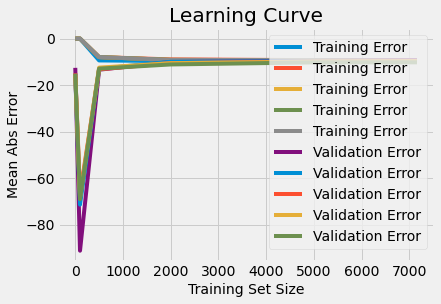

In [45]:
model = LinearRegression()
pipeline = Pipeline([('normalize', Normalizer()),
                    ('est', model)
                    ]
                   )


train_sizes = [1, 100, 500, 2000, 5000, 7161]

train_sizes, train_scores, validation_scores = learning_curve(estimator = pipeline,
                                                             X = X_train,
                                                             y = y_train,
                                                             train_sizes = train_sizes,
                                                             scoring='neg_mean_absolute_error')

plt.style.use('fivethirtyeight')

plt.plot(train_sizes, train_scores, label='Training Error')
plt.plot(train_sizes, validation_scores, label='Validation Error')
plt.ylabel('Mean Abs Error', fontsize=14)
plt.xlabel('Training Set Size', fontsize=14)
plt.title('Learning Curve')
plt.legend()
plt.show()

In [46]:
model = LinearRegression()
pipeline = Pipeline([('normalize', Normalizer()),
                    ('est', model)
                    ]
                   )
pipeline.fit(X_train, y_train)

y_preds = pipeline.predict(X_test)

mae = mean_absolute_error(y_test, y_preds)
print("{} Mean Absolute Error:".format(str(model)), mae)

Mean Absolute Error: 10.462220697522566


In [47]:
coefficients = pipeline.named_steps['est'].coef_

sorted(list(zip(X_train.columns, coefficients)), key=lambda x: x[1], reverse=True)



[('AWAY_PTS_last5', 2.1441482291883356e+16),
 ('HOME_REB_avg', 1.430650402451487e+16),
 ('HOME_FGM_avg', 9707360193764900.0),
 ('HOME_FTM_avg', 4853680096881943.0),
 ('HOME_FG3M_avg', 4853680096881814.0),
 ('HOME_REB_last5', 4814465152854063.0),
 ('HOME_PTS_opp_last5', 4579839493898733.0),
 ('AWAY_REB_opp_avg', 4482790802224287.0),
 ('HOME_OREB_opp_avg', 4203996858094399.0),
 ('HOME_DREB_opp_avg', 4203996858094380.5),
 ('AWAY_FGM_opp_avg', 3989884828025581.0),
 ('AWAY_REB_opp_last5', 3843037400087068.0),
 ('AWAY_REB_avg', 2805725974886746.5),
 ('AWAY_DREB_last5', 2507307637083465.0),
 ('AWAY_OREB_last5', 2507307637083449.5),
 ('AWAY_PTS_avg', 2382510996268671.0),
 ('HOME_PLUS_MINUS_last5', 2274866899075183.5),
 ('AWAY_FTM_opp_avg', 1994942414012683.5),
 ('AWAY_FG3M_opp_avg', 1994942414012643.2),
 ('AWAY_PLUS_MINUS_avg', 1085407045256081.2),
 ('HOME_OREB_opp_last5', 828535901394699.0),
 ('HOME_DREB_opp_last5', 828535901394656.0),
 ('HOME_FG_PCT_opp_avg', 26484.06640625),
 ('AWAY_FG_PCT_

In [55]:
pipeline = Pipeline([('normalize', Normalizer()),
                    ('est', Ridge())
                    ]
                   )

params = {'est__alpha' : [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]}

gs_ridge = GridSearchCV(pipeline, param_grid = params)

gs_ridge.fit(X_train, y_train)

y_preds = gs_ridge.predict(X_test)

mae = mean_absolute_error(y_test, y_preds)
print("Ridge Regression: Mean Absolute Error:", mae)

Ridge Regression: Mean Absolute Error: 10.39432828895719


In [68]:
best_ridge = gs_ridge.best_estimator_
best_ridge

ridge = Ridge(alpha=0.1)
ridge.fit(X_train, y_train)
y_preds = ridge.predict(X_test)

mae = mean_absolute_error(y_test, y_preds)
print("Ridge Regression: Mean Absolute Error:", mae)

coefficients = ridge.coef_

sorted(list(zip(X_train.columns, coefficients)), key=lambda x: x[1], reverse=True)

Ridge Regression: Mean Absolute Error: 10.428797399824058


[('AWAY_FT_PCT_avg', 37.50863756004932),
 ('HOME_FT_PCT_opp_last5', 10.920069489601403),
 ('HOME_FT_PCT_avg', 9.005808490371784),
 ('AWAY_FG3_PCT_opp_avg', 8.149267705642762),
 ('HOME_FT_PCT_last5', 6.944659148441254),
 ('HOME_FG3_PCT_avg', 6.691173696713078),
 ('HOME_WIN_avg', 6.280177331437161),
 ('AWAY_FG_PCT_opp_avg', 3.544155947189591),
 ('HOME_FG_PCT_opp_avg', 3.1270278915642034),
 ('AWAY_FG3_PCT_avg', 1.9765453041777798),
 ('AWAY_FTA_avg', 1.4988580430001914),
 ('HOME_MIN_avg', 1.4009311395270476),
 ('HOME_FG3_PCT_opp_avg', 1.2144485336773192),
 ('AWAY_FT_PCT_opp_avg', 1.061741741001886),
 ('AWAY_FG3M_avg', 0.8632023907257954),
 ('HOME_FG3M_opp_avg', 0.8449121133962154),
 ('HOME_FG3_PCT_opp_last5', 0.8396217071266567),
 ('HOME_STL_avg', 0.7880503900441033),
 ('AWAY_TOV_avg', 0.6453684735376215),
 ('HOME_FG3M_last5', 0.6434288476694399),
 ('AWAY_FTM_last5', 0.6060028568078063),
 ('HOME_FTA_avg', 0.593947758751955),
 ('HOME_FGM_avg', 0.5873903025713377),
 ('HOME_TOV_opp_last5', 0.

In [9]:
pipeline = Pipeline([('normalize', Normalizer()),
                    ('est', Lasso())
                    ]
                   )

params = {'est__alpha' : [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]}

gs_lasso = GridSearchCV(pipeline, param_grid = params)

gs_lasso.fit(X_train, y_train)

y_preds = gs_lasso.predict(X_test)

mae = mean_absolute_error(y_test, y_preds)
print("Lasso Regression: Mean Absolute Error:", mae)

Lasso Regression: Mean Absolute Error: 10.396301052171879


In [10]:
gs_lasso.best_params_

{'est__alpha': 0.001}

In [12]:
lasso = Lasso(alpha=0.001)
lasso.fit(X_train, y_train)

coefficients = lasso.coef_

sorted(list(zip(X_train.columns, coefficients)), key=lambda x: x[1])

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 110297.14345213876, tolerance: 159.22225683646116
  positive)


[('AWAY_FT_PCT_last5', -7.077603611588736),
 ('AWAY_FT_PCT_opp_last5', -6.513901267160642),
 ('AWAY_FG3_PCT_last5', -5.735598535076406),
 ('HOME_FG3_PCT_last5', -5.062284505193603),
 ('AWAY_WIN_avg', -4.1555541890341265),
 ('HOME_WIN_last5', -2.6506244163852837),
 ('HOME_TOV_opp_avg', -1.3898002391657927),
 ('AWAY_FTM_avg', -1.237562823868835),
 ('HOME_FGA_opp_avg', -0.6691747727985262),
 ('HOME_FGM_opp_avg', -0.6494263693142229),
 ('AWAY_TOV_opp_avg', -0.5654227496172015),
 ('AWAY_WIN_last5', -0.5593812250538247),
 ('HOME_FTA_opp_avg', -0.44787782420653255),
 ('HOME_TOV_last5', -0.41813797982198897),
 ('AWAY_STL_opp_avg', -0.4127621366765084),
 ('AWAY_FGM_last5', -0.3770793062001567),
 ('AWAY_FG3A_avg', -0.3728329020851773),
 ('AWAY_FGM_avg', -0.36541995814667727),
 ('HOME_DREB_opp_last5', -0.3497995752355148),
 ('AWAY_PF_avg', -0.33620163924591),
 ('HOME_BLKA_last5', -0.3152980886621888),
 ('AWAY_FTA_last5', -0.30428667145182675),
 ('HOME_AST_opp_avg', -0.2967590950197613),
 ('AWAY_F

In [27]:
from xgboost import XGBRegressor
from xgboost import plot_importance

In [17]:
xgbr = XGBRegressor()

xgbr.fit(X_train, y_train)

y_preds = xgbr.predict(X_test)

mae = mean_absolute_error(y_test, y_preds)

print("XGB Mean Absolute Error:", mae)

XGB Mean Absolute Error: 12.094018729643263


In [19]:
params = {'eta':np.linspace(0.1, 0.3, 3),
         'min_child_weight':[1,3, 5],
         'max_depth':[3, 6, 9],
         'gamma':[0, 0.01, 0.1],
         'subsample':[0.5, 0.7, 1],
         'colsample_bytree':[0.5, 0.7, 1]
         }

xgb_gs = GridSearchCV(estimator=XGBRegressor(),
                     param_grid=params,
                      scoring='neg_mean_absolute_error'
                     )

xgb_gs.fit(X_train, y_train)

y_preds = xgb_gs.predict(X_test)

mae = mean_absolute_error(y_test, y_preds)

print("XGB Mean Absolute Error:", mae)

NameError: name 'xgbr_gs' is not defined

In [23]:
best_xgb = xgb_gs.best_estimator_

y_preds = xgb_gs.predict(X_test)

mae = mean_absolute_error(y_test, y_preds)

print("XGB Mean Absolute Error:", mae)

XGB Mean Absolute Error: 10.565225397921708


In [24]:
print(xgb_gs.best_params_)

{'colsample_bytree': 0.7, 'eta': 0.1, 'gamma': 0, 'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.7}


In [33]:
sorted(list(zip(X_train.columns, best_xgb.feature_importances_)), key=lambda x: x[1], reverse=True)

[('HOME_PLUS_MINUS_avg', 0.04865933),
 ('AWAY_PLUS_MINUS_avg', 0.03362906),
 ('AWAY_WIN_avg', 0.024591759),
 ('HOME_PLUS_MINUS_last5', 0.020613998),
 ('HOME_WIN_avg', 0.017556055),
 ('AWAY_PLUS_MINUS_last5', 0.014812551),
 ('HOME_FGA_avg', 0.011813309),
 ('AWAY_FG_PCT_avg', 0.010896592),
 ('HOME_MIN_opp', 0.010569177),
 ('HOME_AST_last5', 0.009762183),
 ('HOME_FG_PCT_avg', 0.0095533505),
 ('HOME_STL_opp_avg', 0.009227777),
 ('AWAY_AST_avg', 0.00897538),
 ('HOME_DREB_opp_last5', 0.008870462),
 ('AWAY_PTS_avg', 0.008766913),
 ('AWAY_FTA_opp_avg', 0.008464274),
 ('AWAY_PTS_opp_last5', 0.008401272),
 ('AWAY_FG3_PCT_avg', 0.0079286955),
 ('HOME_BLK_avg', 0.0078364),
 ('AWAY_PTS_opp_avg', 0.007564046),
 ('HOME_AST_opp_avg', 0.0073663006),
 ('HOME_AST_opp_last5', 0.0073611373),
 ('AWAY_PFD_avg', 0.007344995),
 ('AWAY_FG_PCT_last5', 0.007325909),
 ('AWAY_STL_opp_avg', 0.007308808),
 ('AWAY_OREB_opp_avg', 0.0072513022),
 ('AWAY_DREB_last5', 0.0071622655),
 ('HOME_FG3_PCT_avg', 0.007111521),
 ('

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

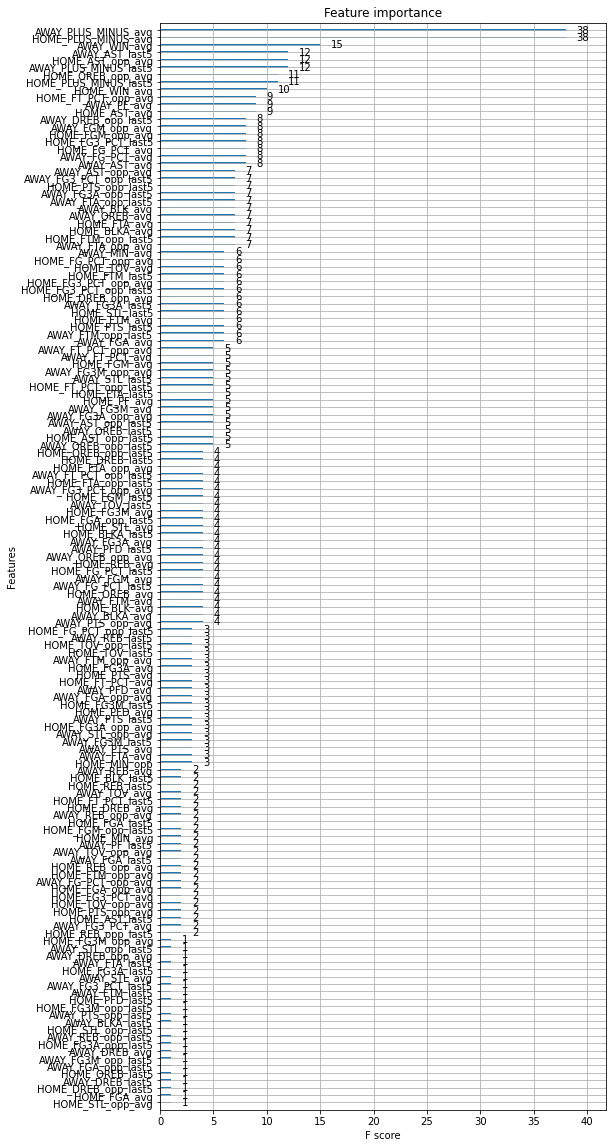

In [31]:
fig, ax = plt.subplots(figsize=(8,20))
plot_importance(best_xgb, ax=ax)

In [18]:
rf = RandomForestRegressor()

rf.fit(X_train, y_train)

y_preds = rf.predict(X_test)

mae = mean_absolute_error(y_test, y_preds)

print("Random Forest Mean Absolute Error", mae)

Random Forest Mean Absolute Error 10.55276841171251


In [ ]:
best_xgb.feature_importances_

In [139]:
df = pd.read_csv('./data/gamelog_2010-11.csv'.format(season))
df = clean_team_gamelog(df)
df = get_weighted_cume_stats(df, n=10)
df = final_preparation(df)
df = remove_correlated_features(df)


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


Correlated Features: ['HOME_BLKA_opp', 'HOME_PFD_opp', 'HOME_PLUS_MINUS_opp', 'HOME_PF_opp', 'AWAY_BLK_opp', 'AWAY_point_diff', 'AWAY_PLUS_MINUS_opp', 'HOME_BLK_opp', 'AWAY_PF_opp', 'AWAY_MIN_opp', 'AWAY_PFD_opp', 'AWAY_BLKA_opp']
Num Features Removed  12


In [200]:
seasons = ['20{}-{}'.format(x, x+1) for x in range(10, 21)]

gamelogs_2010_2020 = []

for season in seasons:
    df = pd.read_csv('./data/gamelog_{}.csv'.format(season))
    df = clean_team_gamelog(df)
    df = get_weighted_cume_stats(df, n=10)
    df = final_preparation(df)
    df = remove_correlated_features(df, 0.8)
    gamelogs_2010_2020.append(df)
    
gamelogs_all_seasons_weighted = pd.concat(gamelogs_2010_2020)
    

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


Correlated Features: ['HOME_REB_opp', 'HOME_BLKA_opp', 'HOME_PLUS_MINUS_opp', 'AWAY_FTA_opp', 'AWAY_PTS_opp', 'HOME_BLK_opp', 'HOME_FG3A_opp', 'AWAY_FG3A_opp', 'AWAY_PTS', 'HOME_PF_opp', 'AWAY_BLK_opp', 'HOME_FG3A', 'AWAY_PLUS_MINUS_opp', 'AWAY_FTA', 'HOME_FTA_opp', 'AWAY_PF_opp', 'AWAY_PFD_opp', 'HOME_PTS_opp', 'HOME_PFD_opp', 'AWAY_REB_opp', 'AWAY_MIN_opp', 'AWAY_BLKA_opp', 'HOME_PTS', 'HOME_FTA', 'AWAY_point_diff', 'AWAY_FG3A', 'AWAY_PFD', 'AWAY_WIN', 'HOME_WIN']
Num Features Removed  29


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


Correlated Features: ['HOME_REB_opp', 'HOME_BLKA_opp', 'HOME_PLUS_MINUS_opp', 'AWAY_FTM_opp', 'AWAY_FTA_opp', 'AWAY_PTS_opp', 'HOME_BLK_opp', 'HOME_FG3A_opp', 'AWAY_PTS', 'HOME_PF_opp', 'AWAY_BLK_opp', 'HOME_FTM_opp', 'HOME_FG3A', 'AWAY_TOV_opp', 'AWAY_PLUS_MINUS_opp', 'AWAY_FTA', 'HOME_PFD', 'HOME_FTA_opp', 'AWAY_PF_opp', 'AWAY_PFD_opp', 'HOME_PTS_opp', 'HOME_PFD_opp', 'AWAY_REB_opp', 'AWAY_MIN_opp', 'HOME_TOV_opp', 'AWAY_BLKA_opp', 'HOME_PTS', 'HOME_FTA', 'AWAY_point_diff', 'AWAY_FG3A', 'AWAY_PFD', 'AWAY_WIN', 'HOME_WIN']
Num Features Removed  33


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


Correlated Features: ['HOME_REB_opp', 'HOME_BLKA_opp', 'HOME_PLUS_MINUS_opp', 'AWAY_FTA_opp', 'AWAY_PTS_opp', 'HOME_BLK_opp', 'HOME_FG3A_opp', 'AWAY_FG3A_opp', 'AWAY_PTS', 'HOME_PF_opp', 'AWAY_BLK_opp', 'HOME_FG3A', 'AWAY_TOV_opp', 'AWAY_PLUS_MINUS_opp', 'AWAY_FTA', 'HOME_PFD', 'HOME_FTA_opp', 'AWAY_PF_opp', 'AWAY_PFD_opp', 'HOME_PTS_opp', 'HOME_PFD_opp', 'AWAY_REB_opp', 'AWAY_MIN_opp', 'AWAY_BLKA_opp', 'HOME_FTA', 'AWAY_point_diff', 'AWAY_FG3A', 'AWAY_PFD', 'AWAY_WIN', 'HOME_WIN']
Num Features Removed  30


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


Correlated Features: ['HOME_REB_opp', 'HOME_BLKA_opp', 'HOME_PLUS_MINUS_opp', 'AWAY_FTM_opp', 'AWAY_FTA_opp', 'AWAY_PTS_opp', 'HOME_BLK_opp', 'HOME_FG3A_opp', 'AWAY_PTS', 'AWAY_FG3A_opp', 'HOME_PF_opp', 'AWAY_BLK_opp', 'HOME_FTM_opp', 'HOME_FG3A', 'AWAY_TOV_opp', 'AWAY_PLUS_MINUS_opp', 'AWAY_FTA', 'HOME_PFD', 'HOME_FTA_opp', 'AWAY_PF_opp', 'AWAY_PFD_opp', 'HOME_PTS_opp', 'HOME_PFD_opp', 'AWAY_REB_opp', 'AWAY_MIN_opp', 'HOME_TOV_opp', 'AWAY_BLKA_opp', 'HOME_PTS', 'HOME_FTA', 'AWAY_point_diff', 'AWAY_FG3A', 'AWAY_PFD', 'AWAY_WIN', 'HOME_WIN']
Num Features Removed  34


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


Correlated Features: ['HOME_REB_opp', 'HOME_BLKA_opp', 'HOME_PLUS_MINUS_opp', 'AWAY_FTA_opp', 'AWAY_PTS_opp', 'HOME_BLK_opp', 'AWAY_PTS', 'AWAY_REB', 'HOME_PF_opp', 'AWAY_BLK_opp', 'HOME_FTM_opp', 'HOME_FG3A', 'AWAY_TOV_opp', 'AWAY_PLUS_MINUS_opp', 'AWAY_FTA', 'HOME_FTA_opp', 'AWAY_PF_opp', 'AWAY_PFD_opp', 'HOME_PTS_opp', 'HOME_PFD_opp', 'AWAY_STL_opp', 'HOME_REB', 'AWAY_REB_opp', 'AWAY_MIN_opp', 'HOME_TOV_opp', 'AWAY_BLKA_opp', 'HOME_PTS', 'HOME_FTA', 'AWAY_point_diff', 'AWAY_FG3A', 'AWAY_WIN', 'HOME_WIN']
Num Features Removed  32


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


Correlated Features: ['HOME_REB_opp', 'HOME_BLKA_opp', 'HOME_PLUS_MINUS_opp', 'AWAY_FTM_opp', 'AWAY_FTA_opp', 'AWAY_PTS_opp', 'HOME_BLK_opp', 'AWAY_PTS', 'AWAY_FG3A_opp', 'HOME_PF_opp', 'AWAY_BLK_opp', 'HOME_FTM_opp', 'HOME_FG3A', 'AWAY_TOV_opp', 'AWAY_PLUS_MINUS_opp', 'AWAY_FTA', 'HOME_PFD', 'HOME_FTA_opp', 'AWAY_PF_opp', 'AWAY_PFD_opp', 'HOME_PTS_opp', 'HOME_PFD_opp', 'HOME_REB', 'AWAY_REB_opp', 'AWAY_MIN_opp', 'HOME_TOV_opp', 'AWAY_BLKA_opp', 'HOME_PTS', 'HOME_FTA', 'AWAY_point_diff', 'AWAY_FG3A', 'AWAY_PFD', 'AWAY_WIN', 'HOME_WIN']
Num Features Removed  34


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


Correlated Features: ['HOME_REB_opp', 'HOME_BLKA_opp', 'HOME_PLUS_MINUS_opp', 'AWAY_FTM_opp', 'AWAY_FTA_opp', 'AWAY_PTS_opp', 'HOME_BLK_opp', 'AWAY_PTS', 'HOME_PF_opp', 'AWAY_BLK_opp', 'HOME_FTM_opp', 'HOME_FG3A', 'AWAY_TOV_opp', 'AWAY_PLUS_MINUS_opp', 'AWAY_FTA', 'HOME_FTA_opp', 'AWAY_PF_opp', 'AWAY_PFD_opp', 'HOME_PTS_opp', 'HOME_PFD_opp', 'AWAY_STL_opp', 'HOME_STL_opp', 'AWAY_REB_opp', 'AWAY_MIN_opp', 'HOME_TOV_opp', 'AWAY_BLKA_opp', 'HOME_PTS', 'HOME_FTA', 'AWAY_point_diff', 'AWAY_FG3A', 'AWAY_PFD', 'AWAY_WIN', 'HOME_WIN']
Num Features Removed  33


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


Correlated Features: ['HOME_REB_opp', 'HOME_BLKA_opp', 'HOME_PLUS_MINUS_opp', 'AWAY_FTM_opp', 'AWAY_FTA_opp', 'AWAY_PTS_opp', 'HOME_BLK_opp', 'AWAY_PTS', 'AWAY_REB', 'HOME_PF_opp', 'AWAY_BLK_opp', 'HOME_FTM_opp', 'HOME_FG3A', 'AWAY_PLUS_MINUS_opp', 'AWAY_FTA', 'HOME_PFD', 'HOME_FTA_opp', 'AWAY_PF_opp', 'AWAY_PFD_opp', 'HOME_PTS_opp', 'HOME_PFD_opp', 'HOME_REB', 'AWAY_REB_opp', 'AWAY_MIN_opp', 'AWAY_BLKA_opp', 'HOME_PTS', 'HOME_FTA', 'AWAY_point_diff', 'AWAY_FG3A', 'AWAY_PFD', 'AWAY_WIN', 'HOME_WIN']
Num Features Removed  32


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


Correlated Features: ['HOME_REB_opp', 'HOME_BLKA_opp', 'HOME_PLUS_MINUS_opp', 'AWAY_FTA_opp', 'AWAY_PTS_opp', 'HOME_BLK_opp', 'AWAY_PTS', 'AWAY_REB', 'HOME_PF_opp', 'AWAY_BLK_opp', 'HOME_FG3A', 'AWAY_TOV_opp', 'AWAY_PLUS_MINUS_opp', 'AWAY_FTA', 'HOME_PFD', 'HOME_FTA_opp', 'AWAY_PF_opp', 'AWAY_PFD_opp', 'HOME_PTS_opp', 'HOME_PFD_opp', 'AWAY_STL_opp', 'HOME_REB', 'AWAY_REB_opp', 'AWAY_MIN_opp', 'HOME_TOV_opp', 'AWAY_BLKA_opp', 'HOME_PTS', 'HOME_FTA', 'AWAY_point_diff', 'AWAY_FG3A', 'AWAY_PFD', 'AWAY_WIN', 'HOME_WIN']
Num Features Removed  33


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


Correlated Features: ['HOME_REB_opp', 'HOME_BLKA_opp', 'HOME_PLUS_MINUS_opp', 'AWAY_FTM_opp', 'AWAY_FTA_opp', 'AWAY_PTS_opp', 'HOME_BLK_opp', 'AWAY_REB', 'HOME_PF_opp', 'AWAY_BLK_opp', 'HOME_FTM_opp', 'HOME_FG3A', 'AWAY_TOV_opp', 'AWAY_PLUS_MINUS_opp', 'AWAY_FTA', 'HOME_PFD', 'HOME_FTA_opp', 'AWAY_PF_opp', 'AWAY_PFD_opp', 'HOME_PTS_opp', 'HOME_PFD_opp', 'HOME_REB', 'AWAY_REB_opp', 'AWAY_MIN_opp', 'HOME_TOV_opp', 'HOME_FG_PCT', 'AWAY_BLKA_opp', 'HOME_PTS', 'HOME_FTA', 'AWAY_point_diff', 'AWAY_FG3A', 'AWAY_PFD', 'AWAY_WIN', 'HOME_WIN']
Num Features Removed  34


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


Correlated Features: ['HOME_REB_opp', 'HOME_BLKA_opp', 'HOME_PLUS_MINUS_opp', 'AWAY_FTM_opp', 'AWAY_FTA_opp', 'AWAY_PTS_opp', 'HOME_BLK_opp', 'AWAY_PTS', 'HOME_PF_opp', 'AWAY_BLK_opp', 'HOME_FTM_opp', 'HOME_FG3A', 'AWAY_TOV_opp', 'AWAY_PLUS_MINUS_opp', 'AWAY_FTA', 'HOME_PFD', 'HOME_FTA_opp', 'AWAY_PF_opp', 'AWAY_PFD_opp', 'HOME_PTS_opp', 'HOME_PFD_opp', 'HOME_REB', 'AWAY_REB_opp', 'AWAY_MIN_opp', 'HOME_TOV_opp', 'HOME_FG_PCT', 'AWAY_BLKA_opp', 'AWAY_FG_PCT', 'HOME_PTS', 'HOME_FTA', 'AWAY_point_diff', 'AWAY_FG3A', 'AWAY_WIN', 'HOME_WIN']
Num Features Removed  34


In [201]:
gamelogs_all_seasons_weighted.to_csv('./data/gamelogs_all_seasons_weighted.csv')

In [202]:
gamelogs_all_seasons_weighted = gamelogs_all_seasons_weighted.dropna(axis=1)

X_train = gamelogs_all_seasons_weighted.loc[gamelogs_all_seasons_weighted['HOME_GAME_DATE'] <= '2018-04-10']
X_train.drop(columns = ['HOME_SEASON_YEAR', 'HOME_TEAM_ABBREVIATION', 'HOME_GAME_DATE',
                       'AWAY_TEAM_ABBREVIATION', 'AWAY_SEASON_YEAR_opp', 'AWAY_TEAM_ID_opp',
                       'AWAY_TEAM_ABBREVIATION_opp', 'AWAY_GAME_DATE_opp', 'AWAY_MATCHUP_opp',
                       'AWAY_WL_opp', 'HOME_SEASON_YEAR_opp', 'HOME_TEAM_ID_opp', 
                        'HOME_TEAM_ABBREVIATION_opp', 'HOME_TEAM_NAME_opp', 'HOME_GAME_DATE_opp', 
                        'HOME_MATCHUP_opp', 'HOME_WL_opp', 'AWAY_TEAM_NAME_opp', 'point_diff'],inplace=True)


y_train = gamelogs_all_seasons_weighted.loc[gamelogs_all_seasons_weighted['HOME_GAME_DATE'] <= '2018-04-10', 'point_diff']


X_test = gamelogs_all_seasons_weighted.loc[gamelogs_all_seasons_weighted['HOME_GAME_DATE'] > '2018-04-10']
X_test.drop(columns = ['HOME_SEASON_YEAR', 'HOME_TEAM_ABBREVIATION', 'HOME_GAME_DATE',
                       'AWAY_TEAM_ABBREVIATION', 'AWAY_SEASON_YEAR_opp', 'AWAY_TEAM_ID_opp',
                       'AWAY_TEAM_ABBREVIATION_opp', 'AWAY_GAME_DATE_opp', 'AWAY_MATCHUP_opp',
                       'AWAY_WL_opp', 'HOME_SEASON_YEAR_opp', 'HOME_TEAM_ID_opp', 
                        'HOME_TEAM_ABBREVIATION_opp', 'HOME_TEAM_NAME_opp', 'HOME_GAME_DATE_opp', 
                        'HOME_MATCHUP_opp', 'HOME_WL_opp', 'AWAY_TEAM_NAME_opp', 'point_diff'],inplace=True)


y_test = gamelogs_all_seasons_weighted.loc[gamelogs_all_seasons_weighted['HOME_GAME_DATE'] > '2018-04-10', 'point_diff'] 



    

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


## Training Models with Weighted Cumulative Stats

In [88]:
X_train

,HOME_MIN,HOME_FGM,HOME_FGA,HOME_FG_PCT,HOME_FG3M,HOME_FG3A,HOME_FG3_PCT,HOME_FTM,HOME_FTA,HOME_FT_PCT,HOME_OREB,HOME_DREB,HOME_REB,HOME_AST,HOME_TOV,HOME_STL,HOME_BLK,HOME_BLKA,HOME_PF,HOME_PFD,HOME_PTS,HOME_PLUS_MINUS,HOME_MIN_opp,HOME_FGM_opp,HOME_FGA_opp,HOME_FG_PCT_opp,HOME_FG3M_opp,HOME_FG3A_opp,HOME_FG3_PCT_opp,HOME_FTM_opp,HOME_FTA_opp,HOME_FT_PCT_opp,HOME_OREB_opp,HOME_DREB_opp,HOME_REB_opp,HOME_AST_opp,HOME_TOV_opp,HOME_STL_opp,HOME_PTS_opp,HOME_WIN,AWAY_MIN,AWAY_FGM,AWAY_FGA,AWAY_FG_PCT,AWAY_FG3M,AWAY_FG3A,AWAY_FG3_PCT,AWAY_FTM,AWAY_FTA,AWAY_FT_PCT,AWAY_OREB,AWAY_DREB,AWAY_REB,AWAY_AST,AWAY_TOV,AWAY_STL,AWAY_BLK,AWAY_BLKA,AWAY_PF,AWAY_PFD,AWAY_PTS,AWAY_PLUS_MINUS,AWAY_FGM_opp,AWAY_FGA_opp,AWAY_FG_PCT_opp,AWAY_FG3M_opp,AWAY_FG3A_opp,AWAY_FG3_PCT_opp,AWAY_FTM_opp,AWAY_FTA_opp,AWAY_FT_PCT_opp,AWAY_OREB_opp,AWAY_DREB_opp,AWAY_REB_opp,AWAY_AST_opp,AWAY_TOV_opp,AWAY_STL_opp,AWAY_PTS_opp,AWAY_WIN
41,48.00,37.75,75.40,0.50080,4.95,16.65,0.30105,16.95,22.95,0.73135,9.30,31.20,40.50,23.45,15.55,4.80,4.80,3.80,19.65,19.70,97.40,-0.75,48.0,39.05,85.80,0.45630,5.70,16.60,0.35195,14.35,19.65,0.73560,12.65,28.15,40.80,21.55,11.40,7.90,98.15,0.40,48.00,37.45,91.90,0.40625,6.40,17.80,0.35625,18.10,24.05,0.76215,17.05,32.25,49.30,17.90,17.85,7.85,5.25,7.55,24.80,21.25,99.40,-7.50,38.55,85.65,0.45140,7.75,22.05,0.33940,22.05,28.75,0.77085,11.00,33.55,44.55,24.50,14.90,8.50,106.90,0.40
2086,48.00,37.90,86.80,0.43735,7.10,19.35,0.36660,14.35,20.05,0.68805,13.80,28.90,42.70,20.95,16.95,10.05,4.35,5.70,24.25,17.90,97.25,-4.05,48.0,36.10,81.85,0.44080,6.05,18.75,0.33140,23.05,28.65,0.79950,13.00,32.75,45.75,21.00,17.65,9.85,101.30,0.50,48.75,36.35,79.55,0.45795,6.20,14.65,0.41490,17.10,24.15,0.70810,10.05,27.00,37.05,18.55,13.55,7.45,4.05,4.60,19.45,19.50,96.00,-2.75,37.80,79.60,0.47810,4.70,17.80,0.26770,18.45,23.85,0.77085,12.20,30.90,43.10,20.90,15.30,8.40,98.75,0.55
685,48.00,33.85,72.95,0.46650,6.80,17.25,0.39560,18.50,23.70,0.77775,10.75,29.85,40.60,22.65,17.30,6.00,7.85,6.70,20.10,20.05,93.00,-0.95,48.0,35.20,80.10,0.44035,6.50,18.70,0.34295,17.05,21.75,0.78125,11.25,25.90,37.15,22.40,13.10,7.60,93.95,0.35,48.00,37.35,89.10,0.41995,6.50,18.25,0.35245,18.80,25.45,0.74820,16.10,31.20,47.30,18.20,18.35,8.05,4.90,7.30,25.00,21.95,100.00,-6.75,37.75,83.75,0.45200,6.90,19.65,0.35240,24.35,30.55,0.79370,11.20,32.05,43.25,24.00,15.00,9.15,106.75,0.35
1817,48.00,38.35,85.35,0.45015,6.95,20.20,0.34380,21.05,26.40,0.79070,10.55,31.50,42.05,19.80,13.25,7.60,3.30,6.65,20.40,21.00,104.70,-1.95,48.0,40.15,85.55,0.46945,6.60,20.35,0.30540,19.75,26.40,0.75475,11.15,33.50,44.65,22.05,13.90,6.35,106.65,0.45,48.00,36.45,84.40,0.43235,7.25,24.05,0.28895,21.55,27.30,0.78165,10.90,31.30,42.20,19.00,16.25,8.35,7.50,3.80,23.20,23.45,101.70,-5.10,39.90,84.70,0.47225,5.90,16.00,0.37425,21.10,28.60,0.74235,11.35,33.65,45.00,22.55,16.55,8.45,106.80,0.20
3409,49.75,38.30,84.70,0.45135,4.25,14.50,0.28445,17.10,24.35,0.69440,13.00,28.25,41.25,19.40,16.70,10.45,4.10,5.35,22.25,22.05,97.95,-5.35,48.0,38.05,80.10,0.47565,8.35,22.10,0.38980,18.85,26.05,0.69470,12.10,33.60,45.70,22.25,19.65,9.35,103.30,0.30,48.50,36.85,80.00,0.46115,5.20,16.50,0.31910,18.90,22.85,0.83265,12.20,25.55,37.75,21.10,13.85,7.70,4.80,5.05,21.25,22.25,97.80,-1.45,36.80,77.60,0.47355,5.60,17.75,0.32320,20.05,25.10,0.79280,11.45,28.40,39.85,19.50,15.45,6.95,99.25,0.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,48.25,41.70,88.45,0.47065,9.50,24.65,0.38235,13.95,17.80,0.78195,10.30,31.00,41.30,23.90,12.95,9.90,3.85,5.45,19.85,18.05,106.85,2.95,48.0,39.05,82.30,0.47570,9.95,28.70,0.34545,15.85,19.35,0.79060,9.35,31.80,41.15,26.60,18.15,6.45,103.90,0.70,48.25,40.45,83.10,0.48700,10.95,28.60,0.36960,23.70,29.15,0.81670,9.15

In [203]:
pipeline = Pipeline([('normalize', Normalizer()),
                    ('est', Lasso())
                    ]
                   )

params = {'est__alpha' : [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]}

gs_lasso = GridSearchCV(pipeline, param_grid = params)

gs_lasso.fit(X_train, y_train)

best_lasso = gs_lasso.best_estimator_

y_preds = best_lasso.predict(X_test)

mae = mean_absolute_error(y_test, y_preds)
print("Lasso Regression: Mean Absolute Error:", mae)


Lasso Regression: Mean Absolute Error: 10.637814241413377


In [93]:
coefficients = best_lasso.named_steps['est'].coef_

sorted(list(zip(X_train.columns, coefficients)), key = lambda x: x[1], reverse=True)

[('HOME_PLUS_MINUS', 130.04725021731883),
 ('AWAY_AST_opp', 53.02186924792169),
 ('AWAY_FGA', 41.9321606908327),
 ('HOME_FTA', 38.637196665654),
 ('HOME_FG3A', 36.380346263193175),
 ('AWAY_FTA_opp', 31.58654355732231),
 ('HOME_PTS', 29.729450790635877),
 ('HOME_STL', 29.30043731159418),
 ('AWAY_REB_opp', 20.292433092429988),
 ('AWAY_FG3A_opp', 16.021230904985146),
 ('HOME_TOV_opp', 12.739165050763184),
 ('HOME_BLK', 9.417116282883713),
 ('AWAY_DREB_opp', 0.026058213216193053),
 ('HOME_MIN', 0.0),
 ('HOME_FGM', -0.0),
 ('HOME_FGA', -0.0),
 ('HOME_FG_PCT', 0.0),
 ('HOME_FG3M', 0.0),
 ('HOME_FG3_PCT', -0.0),
 ('HOME_FTM', 0.0),
 ('HOME_FT_PCT', 0.0),
 ('HOME_OREB', 0.0),
 ('HOME_DREB', -0.0),
 ('HOME_REB', -0.0),
 ('HOME_AST', -0.0),
 ('HOME_TOV', -0.0),
 ('HOME_PF', -0.0),
 ('HOME_PFD', 0.0),
 ('HOME_FGM_opp', -0.0),
 ('HOME_FGA_opp', -0.0),
 ('HOME_FG_PCT_opp', 0.0),
 ('HOME_FG3M_opp', 0.0),
 ('HOME_FG3_PCT_opp', 0.0),
 ('HOME_FTM_opp', -0.0),
 ('HOME_FTA_opp', -0.0),
 ('HOME_FT_PCT_opp

In [204]:
en = ElasticNet()

pipeline = Pipeline([('normalize', Normalizer()),
                    ('est', ElasticNet())
                    ]
                   )

params = {'est__alpha' : [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10],
         'est__l1_ratio':np.linspace(0.1, 0.9, 10)}

gs_en = GridSearchCV(pipeline, param_grid = params, scoring = 'neg_mean_absolute_error')

gs_en.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('normalize', Normalizer()),
                                       ('est', ElasticNet())]),
             param_grid={'est__alpha': [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1,
                                        3, 10],
                         'est__l1_ratio': array([0.1       , 0.18888889, 0.27777778, 0.36666667, 0.45555556,
       0.54444444, 0.63333333, 0.72222222, 0.81111111, 0.9       ])},
             scoring='neg_mean_absolute_error')

In [205]:
best_en = gs_en.best_estimator_
print(gs_en.best_params_)

y_preds = best_en.predict(X_test)
mae = mean_absolute_error(y_test, y_preds)
print("Elastic Net MAE:", mae)

{'est__alpha': 0.001, 'est__l1_ratio': 0.9}
Elastic Net MAE: 10.672540909972067


In [206]:
coefficients = best_en.named_steps['est'].coef_

sorted(list(zip(X_train.columns, coefficients)), key = lambda x: x[1], reverse=True)


[('HOME_PLUS_MINUS', 94.36790513410503),
 ('HOME_FTM', 25.670571427940434),
 ('HOME_FG3M', 23.31781028369466),
 ('AWAY_AST_opp', 20.600315194148898),
 ('AWAY_FGA', 15.263394131565995),
 ('HOME_STL', 13.415974904304221),
 ('AWAY_PF', 13.13301231369262),
 ('AWAY_DREB_opp', 11.805453740037827),
 ('AWAY_BLKA', 9.75430866145832),
 ('HOME_FGM', 7.282539993344933),
 ('HOME_BLK', 5.939770887728991),
 ('AWAY_TOV', 2.696183753078003),
 ('HOME_AST', 0.7769405587724841),
 ('HOME_MIN', 0.0),
 ('HOME_FGA', -0.0),
 ('HOME_FG3_PCT', 0.0),
 ('HOME_FT_PCT', 0.0),
 ('HOME_OREB', -0.0),
 ('HOME_DREB', -0.0),
 ('HOME_PF', 0.0),
 ('HOME_FGM_opp', -0.0),
 ('HOME_FG_PCT_opp', 0.0),
 ('HOME_FG3M_opp', 0.0),
 ('HOME_FG3_PCT_opp', 0.0),
 ('HOME_FT_PCT_opp', 0.0),
 ('AWAY_MIN', 0.0),
 ('AWAY_FG3_PCT', 0.0),
 ('AWAY_FT_PCT', -0.0),
 ('AWAY_OREB', 0.0),
 ('AWAY_DREB', -0.0),
 ('AWAY_STL', -0.0),
 ('AWAY_FGM_opp', 0.0),
 ('AWAY_FGA_opp', -0.0),
 ('AWAY_FG_PCT_opp', 0.0),
 ('AWAY_FG3M_opp', -0.0),
 ('AWAY_FG3_PCT_opp

## Using the Model

In [211]:
X_train.columns

Index(['HOME_MIN', 'HOME_FGM', 'HOME_FGA', 'HOME_FG3M', 'HOME_FG3_PCT',
       'HOME_FTM', 'HOME_FT_PCT', 'HOME_OREB', 'HOME_DREB', 'HOME_AST',
       'HOME_TOV', 'HOME_STL', 'HOME_BLK', 'HOME_BLKA', 'HOME_PF',
       'HOME_PLUS_MINUS', 'HOME_MIN_opp', 'HOME_FGM_opp', 'HOME_FGA_opp',
       'HOME_FG_PCT_opp', 'HOME_FG3M_opp', 'HOME_FG3_PCT_opp',
       'HOME_FT_PCT_opp', 'HOME_OREB_opp', 'HOME_DREB_opp', 'HOME_AST_opp',
       'AWAY_MIN', 'AWAY_FGM', 'AWAY_FGA', 'AWAY_FG3M', 'AWAY_FG3_PCT',
       'AWAY_FTM', 'AWAY_FT_PCT', 'AWAY_OREB', 'AWAY_DREB', 'AWAY_AST',
       'AWAY_TOV', 'AWAY_STL', 'AWAY_BLK', 'AWAY_BLKA', 'AWAY_PF',
       'AWAY_PLUS_MINUS', 'AWAY_FGM_opp', 'AWAY_FGA_opp', 'AWAY_FG_PCT_opp',
       'AWAY_FG3M_opp', 'AWAY_FG3_PCT_opp', 'AWAY_FT_PCT_opp', 'AWAY_OREB_opp',
       'AWAY_DREB_opp', 'AWAY_AST_opp'],
      dtype='object')

In [217]:
from nba_api.stats.endpoints import teamgamelogs

def prep_inputs_for_model(homeTeamAbbr, awayTeamAbbr, season='2020-21'):
    
    gamelogs = teamgamelogs.TeamGameLogs(season_nullable=season).get_data_frames()[0]
    gamelogs_clean = clean_team_gamelog(gamelogs)
        
    home_gl = gamelogs_clean.loc[gamelogs_clean['TEAM_ABBREVIATION'] == homeTeamAbbr]

    away_gl = gamelogs_clean.loc[gamelogs_clean['TEAM_ABBREVIATION'] == awayTeamAbbr]

    home_stats_weighted = get_weighted_cume_stats(home_gl)
    home_stats_weighted = home_stats_weighted.drop(columns=['BLKA_opp', 'PF_opp', 'PLUS_MINUS_opp', 'PFD_opp', 'BLK_opp'])
    home_stats_last = home_stats_weighted.iloc[-1].to_frame().T

    away_stats_weighted = get_weighted_cume_stats(away_gl)
    away_stats_weighted = away_stats_weighted.drop(columns=['BLKA_opp', 'PF_opp', 'PLUS_MINUS_opp', 'PFD_opp', 'BLK_opp'])
    away_stats_last = away_stats_weighted.iloc[-1].to_frame().T
    
    inputs = pd.merge(home_stats_last, away_stats_last, on='SEASON_YEAR')
    # For readability, rename columns    
    new_col_names = ['HOME_' + x[:-2] if x[-2:] == '_x' else 'AWAY_' + x[:-2] for x in inputs.columns.to_list()]
    inputs.columns = new_col_names
    
    columns_needed = ['HOME_MIN', 'HOME_FGM', 'HOME_FGA', 'HOME_FG3M', 'HOME_FG3_PCT',
       'HOME_FTM', 'HOME_FT_PCT', 'HOME_OREB', 'HOME_DREB', 'HOME_AST',
       'HOME_TOV', 'HOME_STL', 'HOME_BLK', 'HOME_BLKA', 'HOME_PF',
       'HOME_PLUS_MINUS', 'HOME_MIN_opp', 'HOME_FGM_opp', 'HOME_FGA_opp',
       'HOME_FG_PCT_opp', 'HOME_FG3M_opp', 'HOME_FG3_PCT_opp',
       'HOME_FT_PCT_opp', 'HOME_OREB_opp', 'HOME_DREB_opp', 'HOME_AST_opp',
       'AWAY_MIN', 'AWAY_FGM', 'AWAY_FGA', 'AWAY_FG3M', 'AWAY_FG3_PCT',
       'AWAY_FTM', 'AWAY_FT_PCT', 'AWAY_OREB', 'AWAY_DREB', 'AWAY_AST',
       'AWAY_TOV', 'AWAY_STL', 'AWAY_BLK', 'AWAY_BLKA', 'AWAY_PF',
       'AWAY_PLUS_MINUS', 'AWAY_FGM_opp', 'AWAY_FGA_opp', 'AWAY_FG_PCT_opp',
       'AWAY_FG3M_opp', 'AWAY_FG3_PCT_opp', 'AWAY_FT_PCT_opp', 'AWAY_OREB_opp',
       'AWAY_DREB_opp', 'AWAY_AST_opp']
    inputs = inputs[columns_needed]
    
    return inputs

In [218]:
prep_inputs_for_model('LAC', 'OKC', season='2020-21')

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,HOME_MIN,HOME_FGM,HOME_FGA,HOME_FG3M,HOME_FG3_PCT,HOME_FTM,HOME_FT_PCT,HOME_OREB,HOME_DREB,HOME_AST,HOME_TOV,HOME_STL,HOME_BLK,HOME_BLKA,HOME_PF,HOME_PLUS_MINUS,HOME_MIN_opp,HOME_FGM_opp,HOME_FGA_opp,HOME_FG_PCT_opp,HOME_FG3M_opp,HOME_FG3_PCT_opp,HOME_FT_PCT_opp,HOME_OREB_opp,HOME_DREB_opp,HOME_AST_opp,AWAY_MIN,AWAY_FGM,AWAY_FGA,AWAY_FG3M,AWAY_FG3_PCT,AWAY_FTM,AWAY_FT_PCT,AWAY_OREB,AWAY_DREB,AWAY_AST,AWAY_TOV,AWAY_STL,AWAY_BLK,AWAY_BLKA,AWAY_PF,AWAY_PLUS_MINUS,AWAY_FGM_opp,AWAY_FGA_opp,AWAY_FG_PCT_opp,AWAY_FG3M_opp,AWAY_FG3_PCT_opp,AWAY_FT_PCT_opp,AWAY_OREB_opp,AWAY_DREB_opp,AWAY_AST_opp
0,48,42.9,84.9,16.85,0.47175,17.45,0.8181,9.35,34.1,25.75,13.85,6.9,4.4,2.65,19.1,14,48,40,85.05,0.47215,12.35,0.36135,0.7586,8.15,30.1,24.15,49,40.25,89.35,12.65,0.32885,15.75,0.7299,7.05,38.1,22.45,13.4,6.55,4.6,4.5,20.15,-6,42.85,92.5,0.46565,12.85,0.3547,0.75545,9.5,40.8,25.1


In [219]:
matchups = [('MIL', 'LAL'),
           ('GSW', 'NYK'),
           ('UTA', 'NOP'),
           ('CLE', 'BKN'),
           ('SAS', 'DAL'),
           ('LAC', 'OKC'),
           ('PHX', 'DEN')
           ]
for matchup in matchups:
    inputs = prep_inputs_for_model(matchup[0], matchup[1])
    prediction = best_en.predict(inputs)
    print(matchup[0], prediction, matchup[1])
    

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


MIL [1.66782142] LAL


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


GSW [3.27103058] NYK


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


UTA [7.74388175] NOP


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


CLE [-4.47118938] BKN


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


SAS [6.10226432] DAL


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


LAC [11.87569392] OKC
PHX [1.38795451] DEN


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


array([1.66638107])